# Data Preparation for OpenEarthMap Semantic Segmentation

**Goal:** Prepare dataset for semantic segmentation baseline (cleaning + preparation)

**Dataset:** OpenEarthMap - Environmental monitoring with 8 classes

**Structure:**
- Section A: Cleaning & Sanity Checks
- Section B: Preparation for Training


---
# Section A: Cleaning & Sanity Checks


## A1) Setup


Purpose: Imports required libraries and utilities.
Inputs: none. Outputs: modules available for later cells.


In [ ]:
import os
import shutil
import importlib.util
import subprocess
import sys
from pathlib import Path

try:
    import google.colab  # noqa: F401
    IN_COLAB = True
except Exception:
    IN_COLAB = False

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

def _resolve_project_dir() -> Path:
    default_dir = Path('/content/drive/MyDrive/DL_project') if IN_COLAB else (Path.cwd() / 'DL_project')
    return Path(os.getenv('DL_PROJECT_DIR', str(default_dir))).expanduser()

PROJECT_DIR = _resolve_project_dir()
PROJECT_DIR.mkdir(parents=True, exist_ok=True)

RAW_DIR = PROJECT_DIR / 'raw_openearthmap'
RAW_DIR.mkdir(parents=True, exist_ok=True)

def _raw_has_splits(raw_dir: Path) -> bool:
    if not raw_dir.exists():
        return False
    candidates = [raw_dir] + [p for p in raw_dir.rglob('*') if p.is_dir()]
    for c in candidates:
        if (c / 'train.txt').exists() and (c / 'val.txt').exists() and (c / 'test.txt').exists():
            return True
    return False

def _ensure_kagglehub():
    if importlib.util.find_spec('kagglehub') is None:
        if IN_COLAB:
            subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', 'kagglehub'])
        else:
            raise ImportError('kagglehub is required to download the dataset. Install it or set DL_PROJECT_DIR to existing data.')
    import kagglehub
    return kagglehub

# Download only if raw dir doesn't already have the split files
if not _raw_has_splits(RAW_DIR):
    kagglehub = _ensure_kagglehub()
    path = kagglehub.dataset_download('aletbm/global-land-cover-mapping-openearthmap')
    print('Downloaded dataset cache path:', path)

    # Copy the downloaded dataset into the persistent project folder
    src = Path(path)
    if src.is_dir():
        for item in src.iterdir():
            dst = RAW_DIR / item.name
            if item.is_dir():
                shutil.copytree(item, dst, dirs_exist_ok=True)
            else:
                shutil.copy2(item, dst)
    else:
        shutil.copy2(src, RAW_DIR / src.name)

print('PROJECT_DIR:', PROJECT_DIR)
print('RAW_DIR:', RAW_DIR)
print('RAW_DIR contents:', list(RAW_DIR.iterdir())[:10])


Mounted at /content/drive


100%|██████████| 8.47G/8.47G [04:51<00:00, 31.2MB/s]

Extracting files...


Downloaded dataset cache path: /root/.cache/kagglehub/datasets/aletbm/global-land-cover-mapping-openearthmap/versions/1
PROJECT_DIR: /content/drive/MyDrive/DL_project
RAW_DIR: /content/drive/MyDrive/DL_project/raw_openearthmap
RAW_DIR contents: [PosixPath('/content/drive/MyDrive/DL_project/raw_openearthmap/test.txt'), PosixPath('/content/drive/MyDrive/DL_project/raw_openearthmap/readme.txt'), PosixPath('/content/drive/MyDrive/DL_project/raw_openearthmap/images'), PosixPath('/content/drive/MyDrive/DL_project/raw_openearthmap/val.txt'), PosixPath('/content/drive/MyDrive/DL_project/raw_openearthmap/label'), PosixPath('/content/drive/MyDrive/DL_project/raw_openearthmap/train.txt')]


Purpose: Imports required libraries and utilities.
Inputs: none. Outputs: modules available for later cells.


In [ ]:
import os
import random
import numpy as np
from pathlib import Path
from typing import Tuple, List, Dict, Optional
from collections import Counter
import json
import zipfile

import torch
import torch.utils.data as data
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from tifffile import imread

# Set random seeds for reproducibility
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Detect GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")


Device: cuda
GPU: Tesla T4
CUDA Version: 12.6


Purpose: Runs a workflow step and updates notebook state.
Inputs: variables/files defined above. Outputs: updated variables, artifacts, or printed status.


In [ ]:
# Define paths - adjust if needed (for Colab, assume archive/ is uploaded or mounted)
# For local Windows: use raw string (r'...') to avoid escape sequence issues
BASE_DIR = PROJECT_DIR

IMG_SIZE = (256, 256)


def find_dataset_root(raw_dir: Path) -> Path:
    candidates = [raw_dir] + [p for p in raw_dir.rglob("*") if p.is_dir()]
    for c in candidates:
        if (c / "train.txt").exists() and (c / "val.txt").exists() and (c / "test.txt").exists():
            return c
    for c in candidates:
        if (c / "images").exists() and ((c / "labels").exists() or (c / "label").exists()):
            return c
    raise FileNotFoundError("Could not find dataset root inside RAW_DIR. Inspect RAW_DIR structure.")


RAW_ROOT = find_dataset_root(RAW_DIR)

# Detect label folder name (label or labels)
if (RAW_ROOT / 'label').exists():
    LABEL_DIR = RAW_ROOT / 'label'
elif (RAW_ROOT / 'labels').exists():
    LABEL_DIR = RAW_ROOT / 'labels'
else:
    raise FileNotFoundError(f"Neither 'label' nor 'labels' folder found in {RAW_ROOT}")

IMAGES_DIR = RAW_ROOT / 'images'
TRAIN_TXT = RAW_ROOT / 'train.txt'
VAL_TXT = RAW_ROOT / 'val.txt'
TEST_TXT = RAW_ROOT / 'test.txt'

print(f"Raw dataset root: {RAW_ROOT}")
print(f"Images directory: {IMAGES_DIR}")
print(f"Label directory: {LABEL_DIR}")
print(f"Prepared output: {BASE_DIR / 'prepared'}")
print(f"Target image size: {IMG_SIZE}")
print(f"\nChecking existence...")
print(f"  Images dir exists: {IMAGES_DIR.exists()}")
print(f"  Label dir exists: {LABEL_DIR.exists()}")
print(f"  train.txt exists: {TRAIN_TXT.exists()}")
print(f"  val.txt exists: {VAL_TXT.exists()}")
print(f"  test.txt exists: {TEST_TXT.exists()}")


Raw dataset root: /content/drive/MyDrive/DL_project/raw_openearthmap
Images directory: /content/drive/MyDrive/DL_project/raw_openearthmap/images
Label directory: /content/drive/MyDrive/DL_project/raw_openearthmap/label
Prepared output: /content/drive/MyDrive/DL_project/prepared
Target image size: (256, 256)

Checking existence...
  Images dir exists: True
  Label dir exists: True
  train.txt exists: True
  val.txt exists: True
  test.txt exists: True


## A2) Read Split Lists


Purpose: Defines helper function(s) like `load_split_list`.
Inputs: none. Outputs: functions available for later use.


In [ ]:
def load_split_list(txt_path: Path) -> List[str]:
    """Load filenames from a text file, stripping whitespace and removing empty lines."""
    if not txt_path.exists():
        raise FileNotFoundError(f"Split file not found: {txt_path}")

    with open(txt_path, 'r') as f:
        lines = [line.strip() for line in f.readlines()]

    # Remove empty lines
    filenames = [line for line in lines if line]
    return filenames

# Load raw split lists
train_files = load_split_list(TRAIN_TXT)
val_files = load_split_list(VAL_TXT)
test_files = load_split_list(TEST_TXT)

raw_train_files = list(train_files)
raw_val_files = list(val_files)
raw_test_files = list(test_files)

print(f"Train files: {len(train_files)}")
print(f"Val files: {len(val_files)}")
print(f"Test files: {len(test_files)}")
print(f"\nTotal files: {len(train_files) + len(val_files) + len(test_files)}")
print(f"\nFirst 5 train files: {train_files[:5]}")
print(f"First 5 val files: {val_files[:5]}")
print(f"First 5 test files: {test_files[:5]}")


Train files: 3000
Val files: 500
Test files: 1500

Total files: 5000

First 5 train files: ['aachen_1.tif', 'aachen_10.tif', 'aachen_12.tif', 'aachen_13.tif', 'aachen_14.tif']
First 5 val files: ['aachen_11.tif', 'aachen_39.tif', 'aachen_42.tif', 'aachen_5.tif', 'aachen_53.tif']
First 5 test files: ['aachen_17.tif', 'aachen_20.tif', 'aachen_23.tif', 'aachen_25.tif', 'aachen_3.tif']


## A3) Verify Files Exist


Purpose: Defines helper function(s) like `verify_files_exist`.
Inputs: none. Outputs: functions available for later use.


In [ ]:
def verify_files_exist(
    filenames: List[str],
    image_dir: Path,
    label_dir: Optional[Path] = None,
    split_name: str = "split"
) -> Dict[str, List[str]]:
    """Verify that image and label files exist. Returns dict with missing files."""
    missing_images = []
    missing_labels = []

    for filename in filenames:
        image_path = image_dir / filename
        if not image_path.exists():
            missing_images.append(filename)

        if label_dir is not None:
            label_path = label_dir / filename
            if not label_path.exists():
                missing_labels.append(filename)

    return {
        'missing_images': missing_images,
        'missing_labels': missing_labels,
        'total_listed': len(filenames),
        'images_found': len(filenames) - len(missing_images),
        'labels_found': len(filenames) - len(missing_labels) if label_dir else 0
    }

# Verify train split
print("=" * 60)
print("TRAIN SPLIT VERIFICATION")
print("=" * 60)
train_report = verify_files_exist(
    train_files,
    IMAGES_DIR / 'train',
    LABEL_DIR / 'train',
    'train'
)
print(f"Total listed: {train_report['total_listed']}")
print(f"Images found: {train_report['images_found']}")
print(f"Images missing: {len(train_report['missing_images'])}")
print(f"Labels found: {train_report['labels_found']}")
print(f"Labels missing: {len(train_report['missing_labels'])}")
if train_report['missing_images']:
    print(f"\nFirst 20 missing images:")
    for f in train_report['missing_images'][:20]:
        print(f"  - {f}")
if train_report['missing_labels']:
    print(f"\nFirst 20 missing labels:")
    for f in train_report['missing_labels'][:20]:
        print(f"  - {f}")

# Verify val split
print("\n" + "=" * 60)
print("VAL SPLIT VERIFICATION")
print("=" * 60)
val_report = verify_files_exist(
    val_files,
    IMAGES_DIR / 'val',
    LABEL_DIR / 'val',
    'val'
)
print(f"Total listed: {val_report['total_listed']}")
print(f"Images found: {val_report['images_found']}")
print(f"Images missing: {len(val_report['missing_images'])}")
print(f"Labels found: {val_report['labels_found']}")
print(f"Labels missing: {len(val_report['missing_labels'])}")
if val_report['missing_images']:
    print(f"\nFirst 20 missing images:")
    for f in val_report['missing_images'][:20]:
        print(f"  - {f}")
if val_report['missing_labels']:
    print(f"\nFirst 20 missing labels:")
    for f in val_report['missing_labels'][:20]:
        print(f"  - {f}")

# Verify test split (images-only expected)
print("\n" + "=" * 60)
print("TEST SPLIT VERIFICATION")
print("=" * 60)
test_report = verify_files_exist(
    test_files,
    IMAGES_DIR / 'test',
    label_dir=None,
    split_name='test'
)
print(f"Total listed: {test_report['total_listed']}")
print(f"Images found: {test_report['images_found']}")
print(f"Images missing: {len(test_report['missing_images'])}")
if test_report['missing_images']:
    print(f"\nFirst 20 missing images:")
    for f in test_report['missing_images'][:20]:
        print(f"  - {f}")

test_label_dir = LABEL_DIR / 'test'
test_label_report = verify_files_exist(
    test_files,
    IMAGES_DIR / 'test',
    label_dir=test_label_dir,
    split_name='test'
)
print(f"Label dir exists: {test_label_dir.exists()}")
print(f"Labels found: {test_label_report['labels_found']}")
print(f"Labels missing: {len(test_label_report['missing_labels'])}")


TRAIN SPLIT VERIFICATION
Total listed: 3000
Images found: 2303
Images missing: 697
Labels found: 2303
Labels missing: 697

First 20 missing images:
  - adelaide_10.tif
  - adelaide_12.tif
  - adelaide_13.tif
  - adelaide_15.tif
  - adelaide_16.tif
  - adelaide_17.tif
  - adelaide_2.tif
  - adelaide_20.tif
  - adelaide_21.tif
  - adelaide_22.tif
  - adelaide_23.tif
  - adelaide_26.tif
  - adelaide_27.tif
  - adelaide_28.tif
  - adelaide_29.tif
  - adelaide_3.tif
  - adelaide_31.tif
  - adelaide_32.tif
  - adelaide_33.tif
  - adelaide_34.tif

First 20 missing labels:
  - adelaide_10.tif
  - adelaide_12.tif
  - adelaide_13.tif
  - adelaide_15.tif
  - adelaide_16.tif
  - adelaide_17.tif
  - adelaide_2.tif
  - adelaide_20.tif
  - adelaide_21.tif
  - adelaide_22.tif
  - adelaide_23.tif
  - adelaide_26.tif
  - adelaide_27.tif
  - adelaide_28.tif
  - adelaide_29.tif
  - adelaide_3.tif
  - adelaide_31.tif
  - adelaide_32.tif
  - adelaide_33.tif
  - adelaide_34.tif

VAL SPLIT VERIFICATION
Total 

Original test split is unlabeled -> cannot compute metrics -> used for inference only.


## A4) Check Image/Label Dimensions Match


Purpose: Defines helper function(s) like `check_dimensions_match`.
Inputs: none. Outputs: functions available for later use.


In [ ]:
def check_dimensions_match(
    filenames: List[str],
    image_dir: Path,
    label_dir: Path,
    split_name: str,
    sample_size: int = 20
) -> Dict:
    """Check if image and label dimensions match for a random sample."""
    # Filter to files that exist
    valid_files = [
        f for f in filenames
        if (image_dir / f).exists() and (label_dir / f).exists()
    ]

    if len(valid_files) == 0:
        print(f"No valid files found for {split_name}")
        return {'mismatches': [], 'checked': 0}

    # Sample randomly
    sample_files = random.sample(valid_files, min(sample_size, len(valid_files)))

    mismatches = []
    for filename in sample_files:
        try:
            img = imread(str(image_dir / filename))
            label = imread(str(label_dir / filename))

            # Handle different array shapes
            if len(img.shape) == 3:
                img_h, img_w = img.shape[:2]
            else:
                img_h, img_w = img.shape

            if len(label.shape) == 3:
                label_h, label_w = label.shape[:2]
            else:
                label_h, label_w = label.shape

            if img_h != label_h or img_w != label_w:
                mismatches.append({
                    'filename': filename,
                    'image_shape': (img_h, img_w),
                    'label_shape': (label_h, label_w)
                })
        except Exception as e:
            print(f"Error checking {filename}: {e}")

    return {'mismatches': mismatches, 'checked': len(sample_files)}

# Check train split
print("Checking TRAIN split dimensions...")
train_dim_check = check_dimensions_match(
    train_files,
    IMAGES_DIR / 'train',
    LABEL_DIR / 'train',
    'train',
    sample_size=20
)
print(f"Checked {train_dim_check['checked']} files")
if train_dim_check['mismatches']:
    print(f"\nâš ï¸  Found {len(train_dim_check['mismatches'])} dimension mismatches:")
    for m in train_dim_check['mismatches']:
        print(f"  {m['filename']}: image {m['image_shape']} vs label {m['label_shape']}")
else:
    print("âœ… All checked files have matching dimensions")

# Check val split
print("\nChecking VAL split dimensions...")
val_dim_check = check_dimensions_match(
    val_files,
    IMAGES_DIR / 'val',
    LABEL_DIR / 'val',
    'val',
    sample_size=20
)
print(f"Checked {val_dim_check['checked']} files")
if val_dim_check['mismatches']:
    print(f"\nâš ï¸  Found {len(val_dim_check['mismatches'])} dimension mismatches:")
    for m in val_dim_check['mismatches']:
        print(f"  {m['filename']}: image {m['image_shape']} vs label {m['label_shape']}")
else:
    print("âœ… All checked files have matching dimensions")


Checking TRAIN split dimensions...
Checked 20 files
âœ… All checked files have matching dimensions

Checking VAL split dimensions...
Checked 20 files
âœ… All checked files have matching dimensions


Purpose: Defines helper function(s) like `_record_image_path`.
Inputs: none. Outputs: functions available for later use.


In [ ]:
# FIX: Build labeled splits from raw train/val (test is unlabeled)

def _record_image_path(record: Dict[str, str]) -> Path:
    return IMAGES_DIR / record["src_split"] / record["filename"]


def _record_label_path(record: Dict[str, str]) -> Path:
    return LABEL_DIR / record["src_split"] / record["filename"]


def _build_labeled_records(filenames: List[str], split_name: str) -> List[Dict[str, str]]:
    records = []
    missing = 0
    for filename in filenames:
        img_path = IMAGES_DIR / split_name / filename
        label_path = LABEL_DIR / split_name / filename
        if img_path.exists() and label_path.exists():
            records.append({"filename": filename, "src_split": split_name})
        else:
            missing += 1
    if missing:
        print(f"{split_name}: missing {missing} labeled pairs")
    return records


train_records = _build_labeled_records(train_files, "train")
val_records = _build_labeled_records(val_files, "val")
labeled_records = train_records + val_records

# Ensure filenames are unique to avoid overwriting in prepared splits
name_counts = Counter([r["filename"] for r in labeled_records])
dupes = [name for name, count in name_counts.items() if count > 1]
if dupes:
    raise ValueError(f"Duplicate filenames across labeled splits: {dupes[:10]}")

rng = random.Random(RANDOM_SEED)
rng.shuffle(labeled_records)

n_total = len(labeled_records)
n_train = int(0.8 * n_total)
n_val = int(0.1 * n_total)

train_labeled_records = labeled_records[:n_train]
val_labeled_records = labeled_records[n_train:n_train + n_val]
test_labeled_records = labeled_records[n_train + n_val:]

train_labeled_files = [r["filename"] for r in train_labeled_records]
val_labeled_files = [r["filename"] for r in val_labeled_records]
test_labeled_files = [r["filename"] for r in test_labeled_records]

infer_test_files = [f for f in test_files if (IMAGES_DIR / "test" / f).exists()]
infer_test_records = [{"filename": f, "src_split": "test"} for f in infer_test_files]

print("=" * 60)
print("LABELED SPLITS (80/10/10 from raw train+val)")
print("=" * 60)
print(f"Total labeled pairs: {n_total}")
print(f"  Train labeled: {len(train_labeled_files)}")
print(f"  Val labeled:   {len(val_labeled_files)}")
print(f"  Test labeled:  {len(test_labeled_files)}")
print(f"Inference-only test images: {len(infer_test_files)}")


train: missing 697 labeled pairs
val: missing 116 labeled pairs
LABELED SPLITS (80/10/10 from raw train+val)
Total labeled pairs: 2687
  Train labeled: 2149
  Val labeled:   268
  Test labeled:  270
Inference-only test images: 1151


Purpose: Runs a workflow step and updates notebook state.
Inputs: variables/files defined above. Outputs: updated variables, artifacts, or printed status.


In [ ]:
# FIX: canonical OpenEarthMap mapping (single source of truth)
CLASS_NAMES = [
    "Bareland",
    "Rangeland",
    "Developed",
    "Road",
    "Tree",
    "Water",
    "Agriculture",
    "Building",
]

CLASS_COLORS = {
    0: (128, 0, 0),
    1: (0, 255, 36),
    2: (148, 148, 148),
    3: (255, 255, 255),
    4: (34, 97, 38),
    5: (0, 69, 255),
    6: (75, 181, 73),
    7: (222, 31, 7),
}

NUM_CLASSES = len(CLASS_NAMES)
VEGETATION_IDS = [CLASS_NAMES.index(name) for name in ("Tree", "Rangeland", "Agriculture")]
WATER_ID = CLASS_NAMES.index("Water")
DEFAULT_IGNORE_INDEX = 255
IGNORE_INDEX = DEFAULT_IGNORE_INDEX
RAW_ID_MIN = 0
RAW_ID_MAX = 8
VALID_RAW_IDS = set(range(RAW_ID_MIN, RAW_ID_MAX + 1))
VALID_TRAIN_IDS = set(range(NUM_CLASSES))


def _to_numpy(array):
    if hasattr(array, "detach"):
        return array.detach().cpu().numpy()
    return np.asarray(array)


def normalize_class_colors(class_colors):
    if isinstance(class_colors, dict):
        return {int(k): tuple(int(x) for x in v) for k, v in class_colors.items()}
    return {i: tuple(int(x) for x in rgb) for i, rgb in enumerate(class_colors)}


def _coerce_to_rgb(mask):
    arr = _to_numpy(mask)
    if arr.ndim == 3 and arr.shape[0] == 3 and arr.shape[2] != 3:
        arr = np.transpose(arr, (1, 2, 0))
    if arr.ndim == 3 and arr.shape[2] > 3:
        arr = arr[:, :, :3]
    return arr


def _as_uint8_rgb(arr):
    if arr.dtype == np.uint8:
        return arr
    if np.issubdtype(arr.dtype, np.floating):
        if arr.max() <= 1.0:
            arr = (arr * 255.0).round()
    arr = np.clip(arr, 0, 255)
    return arr.astype(np.uint8)


def _values_in_range(values, num_classes, ignore_index):
    if ignore_index is not None:
        values = values[values != ignore_index]
    if values.size == 0:
        return True
    return values.min() >= 0 and values.max() < num_classes


def infer_mask_format(mask, num_classes=NUM_CLASSES, ignore_index=None):
    arr = _to_numpy(mask)
    if arr.ndim == 3 and arr.shape[2] == 1:
        arr = arr[:, :, 0]
    if arr.ndim == 2:
        values = np.unique(arr.astype(np.int64))
        if _values_in_range(values, num_classes, ignore_index):
            return "index_2d"
        return "index_2d_out_of_range"
    arr = _coerce_to_rgb(arr)
    if arr.ndim != 3 or arr.shape[2] != 3:
        return "unknown"
    rgb = _as_uint8_rgb(arr)
    r, g, b = rgb[:, :, 0], rgb[:, :, 1], rgb[:, :, 2]
    if np.array_equal(r, g) and np.array_equal(g, b):
        values = np.unique(r.astype(np.int64))
        if _values_in_range(values, num_classes, ignore_index):
            return "index_rgb"
    return "palette_rgb"


def _map_palette_to_ids(rgb, class_colors):
    h, w, _ = rgb.shape
    ids = np.full((h, w), -1, dtype=np.int64)
    for idx, color in class_colors.items():
        color_arr = np.array(color, dtype=np.uint8)
        mask = np.all(rgb == color_arr, axis=-1)
        ids[mask] = idx

    if np.any(ids == -1):
        unknown = np.unique(rgb[ids == -1].reshape(-1, 3), axis=0)
    else:
        unknown = np.empty((0, 3), dtype=np.uint8)
    return ids, unknown


def _map_grayscale_to_ids(values, class_colors):
    gray_map = {
        int(rgb[0]): idx
        for idx, rgb in class_colors.items()
        if rgb[0] == rgb[1] == rgb[2]
    }
    if not gray_map:
        return None
    return gray_map


def decode_mask_to_ids(
    mask,
    class_colors=CLASS_COLORS,
    num_classes=NUM_CLASSES,
    ignore_index=None,
    allow_unknown=False,
    auto_bgr=True,
    verbose=False,
    return_info=False,
):
    colors = normalize_class_colors(class_colors)
    arr = _to_numpy(mask)
    info = {
        "format": None,
        "unknown_colors": [],
        "unknown_values": [],
        "used_bgr": False,
    }

    if arr.ndim == 3 and arr.shape[2] == 1:
        arr = arr[:, :, 0]

    if arr.ndim == 2:
        ids = arr.astype(np.int64)
        values = np.unique(ids)
        if _values_in_range(values, num_classes, ignore_index):
            info["format"] = "index_2d"
            return (ids, info) if return_info else ids

        gray_map = _map_grayscale_to_ids(values, colors)
        if gray_map and np.all(np.isin(values[values != ignore_index], list(gray_map.keys()))):
            info["format"] = "palette_gray"
            for gray_val, class_idx in gray_map.items():
                ids[ids == gray_val] = class_idx
            return (ids, info) if return_info else ids

        if allow_unknown and ignore_index is not None:
            info["format"] = "index_2d_out_of_range"
            bad = values[(values < 0) | (values >= num_classes)]
            bad = bad[bad != ignore_index]
            info["unknown_values"] = bad.tolist()
            ids = ids.copy()
            ids[np.isin(ids, bad)] = ignore_index
            return (ids, info) if return_info else ids

        raise ValueError(
            f"Label mask has values outside [0, {num_classes - 1}] and no valid palette match."
        )

    arr = _coerce_to_rgb(arr)
    if arr.ndim != 3 or arr.shape[2] != 3:
        raise ValueError(f"Label mask must be HxW, HxWx1, or HxWx3. Got shape {arr.shape}.")

    rgb = _as_uint8_rgb(arr)
    r, g, b = rgb[:, :, 0], rgb[:, :, 1], rgb[:, :, 2]
    if np.array_equal(r, g) and np.array_equal(g, b):
        values = np.unique(r.astype(np.int64))
        if _values_in_range(values, num_classes, ignore_index):
            info["format"] = "index_rgb"
            ids = r.astype(np.int64)
            return (ids, info) if return_info else ids

    ids, unknown = _map_palette_to_ids(rgb, colors)
    if unknown.size and auto_bgr:
        ids_bgr, unknown_bgr = _map_palette_to_ids(rgb[:, :, ::-1], colors)
        if unknown_bgr.size < unknown.size:
            info["used_bgr"] = True
            ids = ids_bgr
            unknown = unknown_bgr

    if unknown.size:
        info["unknown_colors"] = [tuple(map(int, c)) for c in unknown.tolist()]
        if allow_unknown and ignore_index is not None:
            ids = ids.copy()
            ids[ids == -1] = ignore_index
            info["format"] = "palette_rgb_unknown"
            return (ids, info) if return_info else ids

        raise ValueError(
            f"Found unknown label colors: {info['unknown_colors'][:10]}"
        )

    info["format"] = "palette_bgr" if info["used_bgr"] else "palette_rgb"
    return (ids, info) if return_info else ids


def encode_ids_to_rgb(mask_ids, class_colors=CLASS_COLORS, ignore_index=None, ignore_color=(0, 0, 0)):
    colors = normalize_class_colors(class_colors)
    ids = _to_numpy(mask_ids)
    if ids.ndim == 3 and ids.shape[2] == 1:
        ids = ids[:, :, 0]
    if ids.ndim != 2:
        raise ValueError(f"mask_ids must be HxW. Got shape {ids.shape}.")

    ids = ids.astype(np.int64)
    h, w = ids.shape
    rgb = np.zeros((h, w, 3), dtype=np.uint8)
    for idx, color in colors.items():
        rgb[ids == idx] = np.array(color, dtype=np.uint8)
    if ignore_index is not None:
        rgb[ids == ignore_index] = np.array(ignore_color, dtype=np.uint8)
    return rgb


def load_label_raw(path: Path) -> np.ndarray:
    img = Image.open(path)
    mode = img.mode
    if mode in ("P", "L"):
        return np.array(img, dtype=np.uint8)
    if mode == "RGB":
        return np.array(img, dtype=np.uint8)
    print(f"Warning: unexpected label mode {mode}; converting to 'L'.")
    return np.array(img.convert("L"), dtype=np.uint8)


def _warn_unexpected_values(values: np.ndarray, valid_values: set, context: str) -> None:
    unexpected = [int(v) for v in np.unique(values) if int(v) not in valid_values]
    if unexpected:
        print(f"Warning: {context} unexpected values: {unexpected[:10]}")


def _remap_raw_ids(raw_ids: np.ndarray) -> np.ndarray:
    raw_ids = np.asarray(raw_ids).astype(np.int64)
    _warn_unexpected_values(raw_ids, VALID_RAW_IDS, "raw label values")
    train_ids = np.full(raw_ids.shape, IGNORE_INDEX, dtype=np.uint8)
    valid = (raw_ids >= 1) & (raw_ids <= RAW_ID_MAX)
    train_ids[valid] = (raw_ids[valid] - 1).astype(np.uint8)
    return train_ids


def to_train_ids(label_raw: np.ndarray) -> np.ndarray:
    arr = np.asarray(label_raw)
    if arr.ndim == 2:
        return _remap_raw_ids(arr)
    if arr.ndim == 3:
        rgb = arr
        if rgb.shape[2] > 3:
            rgb = rgb[:, :, :3]
        if rgb.shape[2] == 3 and np.array_equal(rgb[:, :, 0], rgb[:, :, 1]) and np.array_equal(rgb[:, :, 1], rgb[:, :, 2]):
            return _remap_raw_ids(rgb[:, :, 0])
        train_ids = decode_mask_to_ids(
            rgb,
            CLASS_COLORS,
            NUM_CLASSES,
            ignore_index=IGNORE_INDEX,
            allow_unknown=True,
        )
        train_ids = np.asarray(train_ids).astype(np.int64)
        bad = (train_ids < 0) | ((train_ids >= NUM_CLASSES) & (train_ids != IGNORE_INDEX))
        if np.any(bad):
            _warn_unexpected_values(train_ids[bad], VALID_TRAIN_IDS | {IGNORE_INDEX}, "train ids from RGB")
            train_ids = train_ids.copy()
            train_ids[bad] = IGNORE_INDEX
        return train_ids.astype(np.uint8)
    raise ValueError(f"Label array must be 2D or 3D. Got shape {arr.shape}.")


def make_legend(ax, class_names, class_colors, present_ids=None, loc="upper right", fontsize=7):
    colors = normalize_class_colors(class_colors)
    handles = []
    for idx, name in enumerate(class_names):
        if idx not in colors:
            continue
        if present_ids is not None and idx not in present_ids:
            continue
        color = np.array(colors[idx], dtype=np.float32) / 255.0
        handles.append(mpatches.Patch(color=color, label=f"{idx}: {name}"))
    if handles:
        ax.legend(handles=handles, fontsize=fontsize, loc=loc, framealpha=0.9)


IGNORE_INDEX = DEFAULT_IGNORE_INDEX

print("Class mapping (id -> name -> color):")
for idx in range(NUM_CLASSES):
    rgb = CLASS_COLORS[idx]
    hex_color = f"#{rgb[0]:02X}{rgb[1]:02X}{rgb[2]:02X}"
    print(f"  {idx}: {CLASS_NAMES[idx]:20s} RGB{rgb} {hex_color}")
print(f"Vegetation IDs: {VEGETATION_IDS}")
print(f"Water ID: {WATER_ID}")


Class mapping (id -> name -> color):
  0: Bareland             RGB(128, 0, 0) #800000
  1: Rangeland            RGB(0, 255, 36) #00FF24
  2: Developed            RGB(148, 148, 148) #949494
  3: Road                 RGB(255, 255, 255) #FFFFFF
  4: Tree                 RGB(34, 97, 38) #226126
  5: Water                RGB(0, 69, 255) #0045FF
  6: Agriculture          RGB(75, 181, 73) #4BB549
  7: Building             RGB(222, 31, 7) #DE1F07
Vegetation IDs: [4, 1, 6]
Water ID: 5


Purpose: Defines helper function(s) like `scan_label_formats`.
Inputs: none. Outputs: functions available for later use.


In [ ]:
def scan_label_formats(
    filenames: List[str],
    label_dir: Path,
    split_name: str,
    sample_size: int = 30,
) -> Dict:
    """Scan a sample of labels to infer format and detect unexpected raw values."""
    valid_files = [f for f in filenames if (label_dir / f).exists()]
    if not valid_files:
        return {"format_counts": Counter(), "unexpected_values": {}, "checked": 0}

    files_to_check = random.sample(valid_files, min(sample_size, len(valid_files)))
    format_counts = Counter()
    unexpected_values = {}

    for filename in files_to_check:
        label_path = label_dir / filename
        label_img = Image.open(label_path)
        label_raw = load_label_raw(label_path)

        if label_raw.ndim == 2:
            format_counts["index_2d"] += 1
            values = np.unique(label_raw.astype(np.int64))
            bad = values[(values < RAW_ID_MIN) | (values > RAW_ID_MAX)]
            if bad.size:
                unexpected_values[filename] = bad.tolist()
        else:
            format_counts["rgb"] += 1

    return {
        "format_counts": format_counts,
        "unexpected_values": unexpected_values,
        "checked": len(files_to_check),
    }


print("Scanning label formats (sample)...")
train_scan = scan_label_formats(train_files, LABEL_DIR / 'train', 'train', sample_size=30)
val_scan = scan_label_formats(val_files, LABEL_DIR / 'val', 'val', sample_size=30)

print(f"Train formats: {train_scan['format_counts']}")
print(f"Val formats: {val_scan['format_counts']}")
print(f"IGNORE_INDEX fixed to {IGNORE_INDEX} (raw 0 -> ignore)")

if train_scan['unexpected_values']:
    print("Train unexpected raw values (sample):")
    for fname, values in list(train_scan['unexpected_values'].items())[:5]:
        print(f"  {fname}: {values}")
if val_scan['unexpected_values']:
    print("Val unexpected raw values (sample):")
    for fname, values in list(val_scan['unexpected_values'].items())[:5]:
        print(f"  {fname}: {values}")


Scanning label formats (sample)...
Train formats: Counter({'index_2d': 30})
Val formats: Counter({'index_2d': 30})
IGNORE_INDEX fixed to 255 (raw 0 -> ignore)


Purpose: Runs a workflow step and updates notebook state.
Inputs: variables/files defined above. Outputs: updated variables, artifacts, or printed status.


DIAGNOSTIC: raw vs remapped labels

khartoum_22.tif:
  PIL mode: L
  Raw shape: (650, 650), dtype: uint8
  Raw min/max: 1 / 8
  Raw unique (first 20): [1, 2, 3, 4, 5, 8]


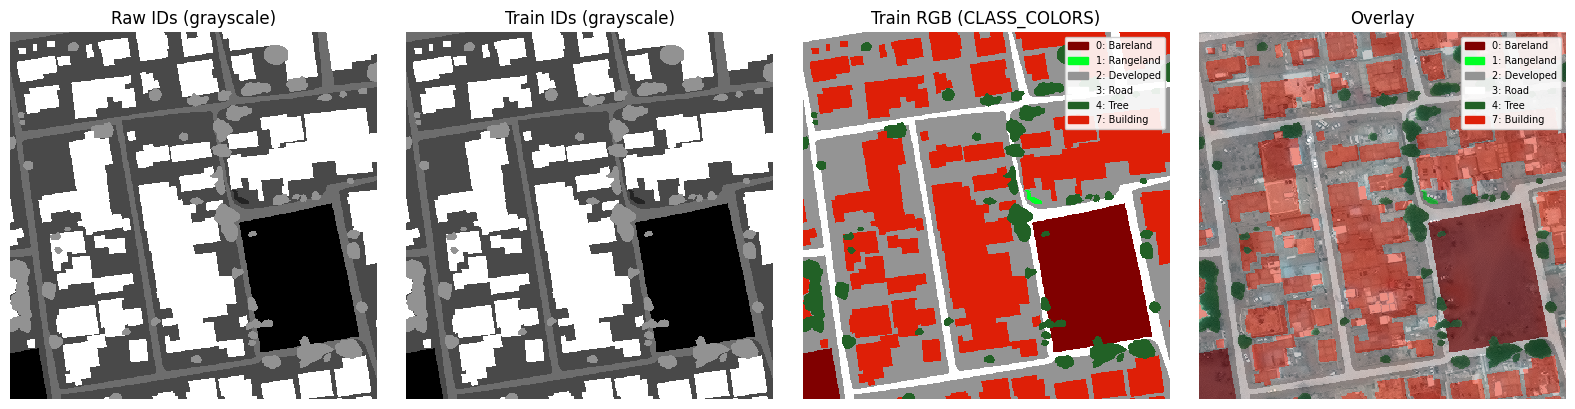


slaskie_26.tif:
  PIL mode: L
  Raw shape: (1024, 1024), dtype: uint8
  Raw min/max: 1 / 8
  Raw unique (first 20): [1, 2, 3, 4, 5, 6, 8]


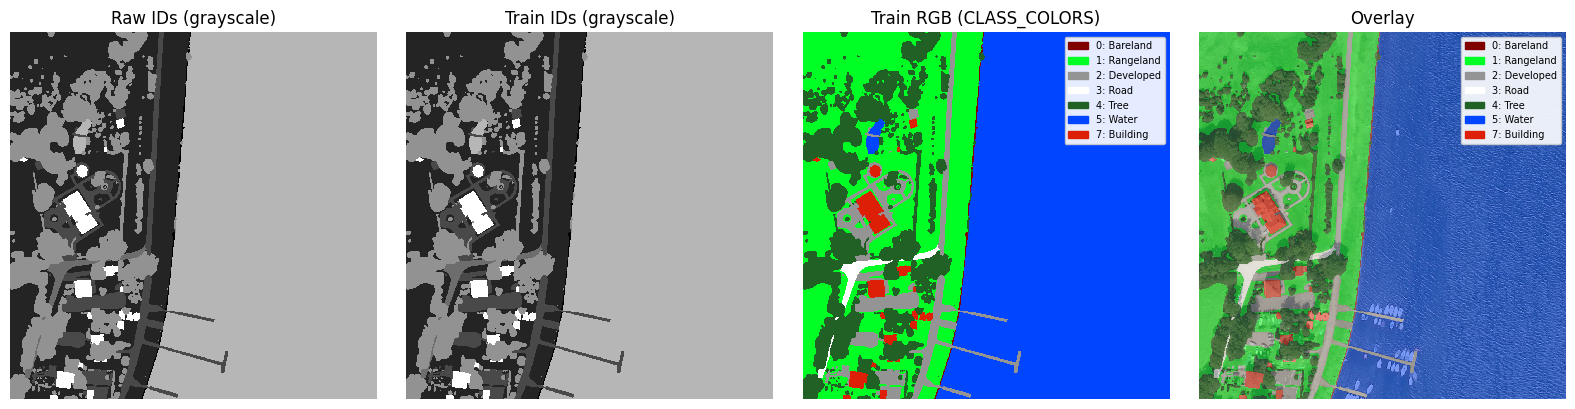


muenster_5.tif:
  PIL mode: L
  Raw shape: (1000, 1000), dtype: uint8
  Raw min/max: 2 / 8
  Raw unique (first 20): [2, 3, 4, 5, 6, 8]


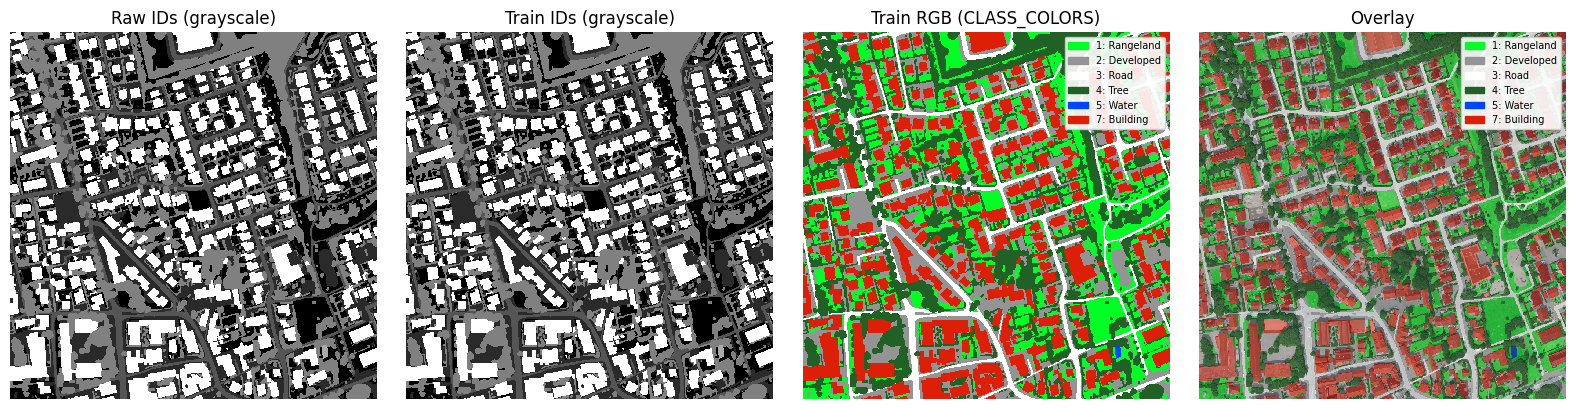

In [ ]:
print("=" * 80)
print("DIAGNOSTIC: raw vs remapped labels")
print("=" * 80)

sample_files = random.sample(train_files, min(3, len(train_files)))
for fname in sample_files:
    img_path = IMAGES_DIR / 'train' / fname
    label_path = LABEL_DIR / 'train' / fname

    label_img = Image.open(label_path)
    label_raw = load_label_raw(label_path)

    print(f"\n{fname}:")
    print(f"  PIL mode: {label_img.mode}")
    print(f"  Raw shape: {label_raw.shape}, dtype: {label_raw.dtype}")

    raw_display = None
    if label_raw.ndim == 2:
        raw_values = np.unique(label_raw.astype(np.int64))
        print(f"  Raw min/max: {raw_values.min()} / {raw_values.max()}")
        print(f"  Raw unique (first 20): {raw_values[:20].tolist()}")
        raw_display = label_raw
    else:
        rgb = label_raw[:, :, :3]
        if np.array_equal(rgb[:, :, 0], rgb[:, :, 1]) and np.array_equal(rgb[:, :, 1], rgb[:, :, 2]):
            raw_values = np.unique(rgb[:, :, 0].astype(np.int64))
            print(f"  Raw min/max: {raw_values.min()} / {raw_values.max()}")
            print(f"  Raw unique (first 20): {raw_values[:20].tolist()}")
            raw_display = rgb[:, :, 0]
        else:
            colors = np.unique(rgb.reshape(-1, 3), axis=0)
            print(f"  Raw unique RGB colors: {len(colors)}")
            print(f"  Raw colors (first 10): {colors[:10].tolist()}")
            raw_display = rgb[:, :, 0]

    train_ids = to_train_ids(label_raw)
    present_ids = np.unique(train_ids)
    if IGNORE_INDEX is not None:
        present_ids = present_ids[present_ids != IGNORE_INDEX]

    label_rgb = encode_ids_to_rgb(
        train_ids,
        CLASS_COLORS,
        ignore_index=IGNORE_INDEX,
        ignore_color=(0, 0, 0),
    )

    img = imread(str(img_path))
    if img.ndim == 2:
        img = np.stack([img] * 3, axis=-1)
    elif img.ndim == 3:
        if img.shape[2] > 3:
            img = img[:, :, :3]
        elif img.shape[0] == 3 and img.shape[2] != 3:
            img = np.transpose(img, (1, 2, 0))

    if img.dtype != np.uint8:
        img = img.astype(np.float32)
        if img.max() > 1.0:
            img = img / 255.0
        img = np.clip(img, 0, 1)
    else:
        img = img.astype(np.float32) / 255.0

    alpha = 0.5
    overlay = img * (1 - alpha) + (label_rgb.astype(np.float32) / 255.0) * alpha

    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    axes[0].imshow(raw_display, cmap='gray', interpolation='nearest')
    axes[0].set_title('Raw IDs (grayscale)')
    axes[0].axis('off')

    axes[1].imshow(train_ids, cmap='gray', interpolation='nearest')
    axes[1].set_title('Train IDs (grayscale)')
    axes[1].axis('off')

    axes[2].imshow(label_rgb, interpolation='nearest')
    axes[2].set_title('Train RGB (CLASS_COLORS)')
    axes[2].axis('off')
    make_legend(axes[2], CLASS_NAMES, CLASS_COLORS, present_ids=present_ids.tolist())

    axes[3].imshow(overlay, interpolation='nearest')
    axes[3].set_title('Overlay')
    axes[3].axis('off')
    make_legend(axes[3], CLASS_NAMES, CLASS_COLORS, present_ids=present_ids.tolist())

    plt.tight_layout()
    plt.show()


## A6) Visual Inspection Grid


Purpose: Defines helper function(s) like `decode_mask_ids_to_rgb`.
Inputs: none. Outputs: functions available for later use.


In [ ]:
def decode_mask_ids_to_rgb(mask_ids: np.ndarray) -> np.ndarray:
    rgb = np.zeros((mask_ids.shape[0], mask_ids.shape[1], 3), dtype=np.uint8)
    for cls, color in CLASS_COLORS.items():
        rgb[mask_ids == cls] = np.array(color, dtype=np.uint8)
    return rgb


def show_mask_ids_and_rgb(label_ids: np.ndarray) -> None:
    """Sanity display: IDs (grayscale) and decoded RGB."""
    ids = np.asarray(label_ids)
    if ids.ndim == 3 and ids.shape[2] == 1:
        ids = ids[:, :, 0]

    unique_ids = np.unique(ids)
    if IGNORE_INDEX is not None:
        unique_ids = unique_ids[unique_ids != IGNORE_INDEX]

    print(f"Unique IDs (excluding ignore): {unique_ids.tolist()}")
    if unique_ids.size:
        print(f"Min/Max IDs (excluding ignore): {unique_ids.min()} / {unique_ids.max()}")
    else:
        print("Min/Max IDs (excluding ignore): n/a")

    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    axes[0].imshow(ids, cmap="gray", interpolation="nearest")
    axes[0].set_title("Mask IDs (grayscale)")
    axes[0].axis("off")

    label_rgb = encode_ids_to_rgb(
        ids,
        CLASS_COLORS,
        ignore_index=IGNORE_INDEX,
        ignore_color=(0, 0, 0),
    )
    axes[1].imshow(label_rgb, interpolation="nearest")
    axes[1].set_title("Mask RGB (CLASS_COLORS)")
    axes[1].axis("off")
    plt.tight_layout()
    plt.show()


def visualize_sample(
    filename: str,
    image_dir: Path,
    label_dir: Path,
    ax1, ax2, ax3
):
    """Visualize a single sample: image, decoded label, and overlay."""
    img_path = image_dir / filename
    label_path = label_dir / filename

    img = imread(str(img_path))
    label_raw = load_label_raw(label_path)

    # VISUALIZATION FIX: normalize image to [0, 1]
    if img.dtype != np.uint8:
        img = img.astype(np.float32)
        if img.max() > 1.0:
            img = img / 255.0
        img = np.clip(img, 0, 1)
    else:
        img = img.astype(np.float32) / 255.0

    # VISUALIZATION FIX: remap raw IDs to training IDs
    label_ids = to_train_ids(label_raw)


    # VISUALIZATION FIX: encode IDs to RGB with CLASS_COLORS
    label_rgb = encode_ids_to_rgb(
        label_ids,
        CLASS_COLORS,
        ignore_index=IGNORE_INDEX,
        ignore_color=(0, 0, 0),
    )

    present_ids = np.unique(label_ids)
    if IGNORE_INDEX is not None:
        present_ids = present_ids[present_ids != IGNORE_INDEX]
    present_ids = present_ids.tolist()

    # Plot RGB image
    ax1.imshow(img)
    ax1.set_title(f"""RGB Image
{filename}""", fontsize=10)
    ax1.axis('off')

    # Plot label mask (decoded RGB)
    ax2.imshow(label_rgb, interpolation="nearest")
    ax2.set_title("Label Mask (CLASS_COLORS)", fontsize=10)
    ax2.axis('off')
    make_legend(ax2, CLASS_NAMES, CLASS_COLORS, present_ids=present_ids)

    # Plot overlay
    mask_alpha = 0.5
    # VISUALIZATION FIX: blend with decoded RGB to avoid palette artifacts
    label_overlay = label_rgb.astype(np.float32) / 255.0
    overlay = img * (1 - mask_alpha) + label_overlay * mask_alpha
    overlay = np.clip(overlay, 0, 1)
    ax3.imshow(overlay, interpolation="nearest")
    ax3.set_title("Overlay (50% transparency)", fontsize=10)
    ax3.axis('off')
    make_legend(ax3, CLASS_NAMES, CLASS_COLORS, present_ids=present_ids)


# Get 3 random samples from train
valid_train_files = [
    f for f in train_files
    if (IMAGES_DIR / 'train' / f).exists() and (LABEL_DIR / 'train' / f).exists()
]
sample_files = random.sample(valid_train_files, min(3, len(valid_train_files)))

if sample_files:
    fig, axes = plt.subplots(len(sample_files), 3, figsize=(15, 5 * len(sample_files)))
    if len(sample_files) == 1:
        axes = axes.reshape(1, -1)

    for i, filename in enumerate(sample_files):
        visualize_sample(
            filename,
            IMAGES_DIR / 'train',
            LABEL_DIR / 'train',
            axes[i, 0],
            axes[i, 1],
            axes[i, 2],
        )

    plt.tight_layout()
    plt.savefig('sample_visualizations.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("Sample visualizations saved to 'sample_visualizations.png'")
else:
    print("No valid samples found for visualization.")


Output hidden; open in https://colab.research.google.com to view.

---
# Section B: Preparation for Training


## B1) Convert Label RGB Mask to Class-Index Mask


Purpose: Defines helper function(s) like `rgb_to_class_mask`.
Inputs: none. Outputs: functions available for later use.


In [ ]:
def rgb_to_class_mask(label_rgb: np.ndarray, verbose: bool = False) -> np.ndarray:
    """
    Convert a label mask to training IDs using the shared remap.
    """
    ids = to_train_ids(label_rgb)
    if verbose:
        unique = np.unique(ids)
        if IGNORE_INDEX is not None:
            unique = unique[unique != IGNORE_INDEX]
        print(f"  unique train IDs: {unique.tolist()}")
    return ids

# Test the conversion function
print("Testing RGB to class-index conversion...")
test_file = valid_train_files[0] if valid_train_files else None
if test_file:
    test_label = imread(str(LABEL_DIR / 'train' / test_file))
    print(f"Test label shape: {test_label.shape}, dtype: {test_label.dtype}")

    try:
        test_class_mask = rgb_to_class_mask(test_label, verbose=True)
        print("OK: Conversion successful")
        print(f"   Class mask shape: {test_class_mask.shape}, dtype: {test_class_mask.dtype}")
        print(f"   Class values range: [{test_class_mask.min()}, {test_class_mask.max()}]")
        print(f"   Unique classes: {np.unique(test_class_mask).tolist()}")
    except ValueError as e:
        print(f"Conversion failed: {e}")
else:
    print("No valid files found for testing")


Testing RGB to class-index conversion...
Test label shape: (1000, 1000), dtype: uint8
  unique train IDs: [1, 2, 3, 4, 5, 6, 7]
OK: Conversion successful
   Class mask shape: (1000, 1000), dtype: uint8
   Class values range: [1, 255]
   Unique classes: [1, 2, 3, 4, 5, 6, 7, 255]


**Note on RGB-to-class conversion performance:**

The RGB-to-class conversion is implemented with explicit matching for clarity and correctness. For large-scale training with very high-resolution images, a vectorized LUT-based approach could be used for speed optimization. The current implementation prioritizes correctness and maintainability.


## B2) Compute Class Distribution


Purpose: Imports required libraries and utilities.
Inputs: none. Outputs: modules available for later cells.


In [ ]:
# Verification: Check raw values and remapped IDs in label files
import numpy as np
import random
from tifffile import imread

print("=" * 80)
print("VERIFICATION: Checking label formats and remapped IDs")
print("=" * 80)

# Sample 10 random label files from train
label_dir = LABEL_DIR / 'train'
all_label_files = list(label_dir.glob("*.tif"))
if len(all_label_files) == 0:
    all_label_files = list(label_dir.glob("*.tiff"))

sample_files = random.sample(all_label_files, min(10, len(all_label_files)))

print(f"Checking {len(sample_files)} random label files from train split...")
print(f"Expected train IDs: 0..{NUM_CLASSES - 1}, IGNORE_INDEX={IGNORE_INDEX}")
print("\n" + "-" * 80)

for p in sample_files:
    try:
        label_img = Image.open(p)
        label_raw = load_label_raw(p)
        train_ids = to_train_ids(label_raw)

        print(f"{p.name}:")
        print(f"  PIL mode: {label_img.mode}")
        print(f"  Raw shape: {label_raw.shape}, dtype: {label_raw.dtype}")

        if label_raw.ndim == 2:
            raw_vals = np.unique(label_raw.astype(np.int64))
            print(f"  Raw values (first 20): {raw_vals[:20].tolist()}")
        else:
            rgb = label_raw[:, :, :3].astype(np.uint8)
            colors = np.unique(rgb.reshape(-1, 3), axis=0)
            print(f"  Raw unique RGB colors: {len(colors)}")
            print(f"  First 10 colors: {colors[:10].tolist()}")

        unique_train = np.unique(train_ids)
        if IGNORE_INDEX is not None:
            unique_train = unique_train[unique_train != IGNORE_INDEX]
        print(f"  Train IDs: {unique_train.tolist()}")
    except Exception as exc:
        print(f"Error reading {p.name}: {exc}")


VERIFICATION: Checking label formats and remapped IDs
Checking 10 random label files from train split...
Expected train IDs: 0..7, IGNORE_INDEX=255

--------------------------------------------------------------------------------
swietokrzyskie_18.tif:
  PIL mode: L
  Raw shape: (1024, 1024), dtype: uint8
  Raw values (first 20): [0, 2, 3, 5, 6, 7, 8]
  Train IDs: [1, 2, 4, 5, 6, 7]
vegas_44.tif:
  PIL mode: L
  Raw shape: (650, 650), dtype: uint8
  Raw values (first 20): [2, 3, 4, 5, 8]
  Train IDs: [1, 2, 3, 4, 7]
viru_21.tif:
  PIL mode: L
  Raw shape: (1024, 1024), dtype: uint8
  Raw values (first 20): [2, 3, 4, 5, 6, 7, 8]
  Train IDs: [1, 2, 3, 4, 5, 6, 7]
zanzibar_18.tif:
  PIL mode: L
  Raw shape: (1024, 1024), dtype: uint8
  Raw values (first 20): [2, 3, 4, 5, 7, 8]
  Train IDs: [1, 2, 3, 4, 6, 7]
dortmund_50.tif:
  PIL mode: L
  Raw shape: (1000, 1000), dtype: uint8
  Raw values (first 20): [2, 3, 4, 5, 6, 7, 8]
  Train IDs: [1, 2, 3, 4, 5, 6, 7]
wielkopolskie_35.tif:
  PIL m

### Normalization Strategy

We use ImageNet mean and standard deviation for normalization. This choice is justified because:

- **Aerial RGB images share similar low-level statistics** with natural images
- **Enables transfer learning** with pretrained encoders (ResNet, EfficientNet, etc.)
- **Standard practice** in semantic segmentation baselines
- Dataset-specific normalization could be computed, but ImageNet stats work well for aerial imagery and are more generalizable


Purpose: Defines helper function(s) like `compute_class_distribution`.
Inputs: none. Outputs: functions available for later use.


Computing class distribution for train_labeled (2149 files)...
  Processed 500/2149 files...
  Processed 1000/2149 files...
  Processed 1500/2149 files...
  Processed 2000/2149 files...
Computing class distribution for val_labeled (268 files)...

CLASS DISTRIBUTION - TRAIN
Class                Name                      Pixel Count     Percentage     
--------------------------------------------------------------------------------
0                    Bareland                  38,411,143      1.84           %
1                    Rangeland                 437,957,181     21.01          %
2                    Developed                 393,152,933     18.86          %
3                    Road                      142,326,854     6.83           %
4                    Tree                      384,816,787     18.46          %
5                    Water                     64,272,715      3.08           %
6                    Agriculture               264,086,632     12.67          %
7     

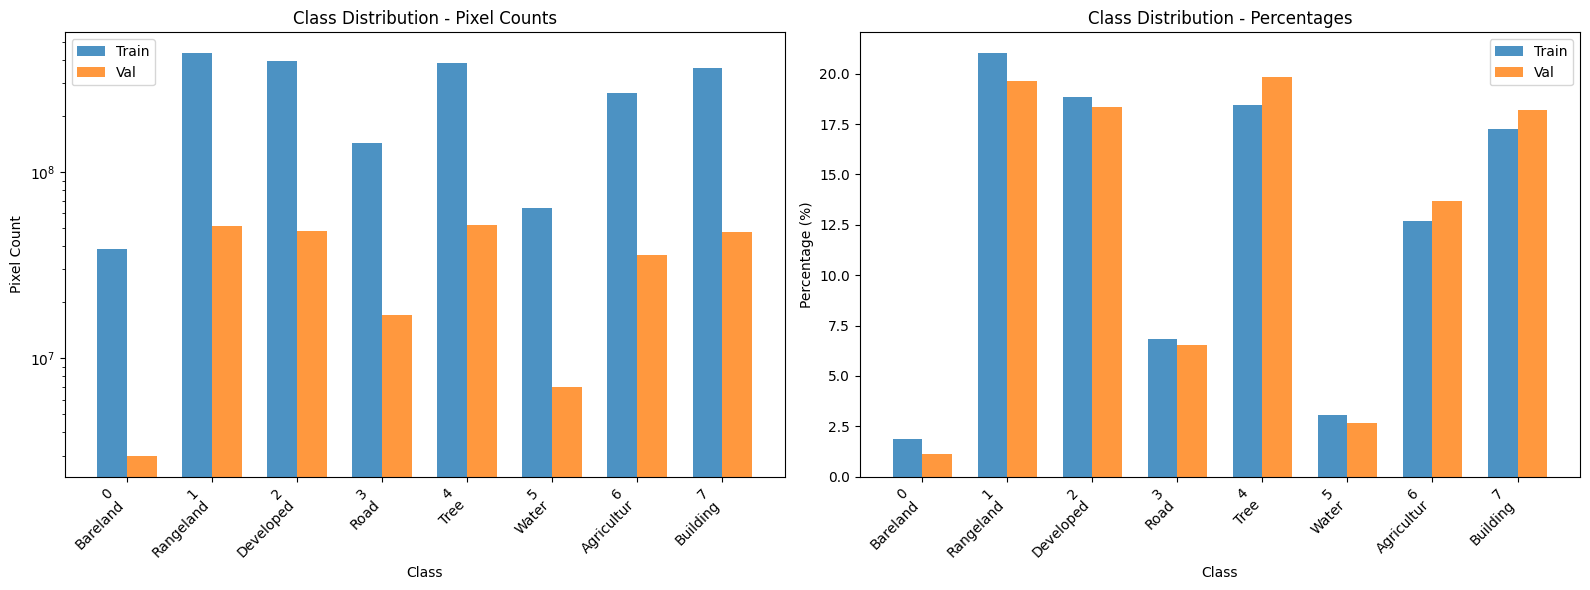


CLASS IMBALANCE ANALYSIS
Train split (sorted by percentage):
  Bareland            :   1.84%
  Water               :   3.08%
  Road                :   6.83%
  Agriculture         :  12.67%
  Building            :  17.26%
  Tree                :  18.46%
  Developed           :  18.86%
  Rangeland           :  21.01%

Imbalance ratio (max/min): 11.40x

Note: Significant class imbalance detected. Consider using:
  - Weighted loss functions (e.g., weighted CrossEntropyLoss)
  - Focal loss
  - Class-balanced sampling strategies


In [ ]:
def compute_class_distribution(
    records: List[Dict[str, str]],
    split_name: str
) -> Dict[int, int]:
    """Compute pixel counts per class for a split."""
    valid_records = [r for r in records if _record_label_path(r).exists()]

    class_counts = {i: 0 for i in range(NUM_CLASSES)}
    total_pixels = 0

    print(f"Computing class distribution for {split_name} ({len(valid_records)} files)...")

    for idx, record in enumerate(valid_records):
        if (idx + 1) % 500 == 0:
            print(f"  Processed {idx + 1}/{len(valid_records)} files...")

        try:
            label_raw = load_label_raw(_record_label_path(record))
            class_mask = to_train_ids(label_raw)
            if IGNORE_INDEX is not None:
                class_mask = class_mask[class_mask != IGNORE_INDEX]

            if class_mask.size == 0:
                continue

            unique_classes, counts = np.unique(class_mask, return_counts=True)
            for cls, count in zip(unique_classes, counts):
                if cls in class_counts:
                    class_counts[cls] += int(count)

            total_pixels += class_mask.size
        except Exception as e:
            print(f"Error processing {record['filename']}: {e}")

    return class_counts, total_pixels

# Compute for train/val labeled splits
train_class_counts, train_total_pixels = compute_class_distribution(
    train_labeled_records,
    'train_labeled'
)

val_class_counts, val_total_pixels = compute_class_distribution(
    val_labeled_records,
    'val_labeled'
)

# Print tables
print("\n" + "=" * 80)
print("CLASS DISTRIBUTION - TRAIN")
print("=" * 80)
print(f"{'Class':<20} {'Name':<25} {'Pixel Count':<15} {'Percentage':<15}")
print("-" * 80)
train_percentages = {}
for cls in range(NUM_CLASSES):
    count = train_class_counts[cls]
    pct = (count / train_total_pixels * 100) if train_total_pixels > 0 else 0.0
    train_percentages[cls] = pct
    print(f"{cls:<20} {CLASS_NAMES[cls]:<25} {count:<15,} {pct:<15.2f}%")
print(f"{'Total':<20} {'':<25} {train_total_pixels:<15,} {'100.00%':<15}")

print("\n" + "=" * 80)
print("CLASS DISTRIBUTION - VAL")
print("=" * 80)
print(f"{'Class':<20} {'Name':<25} {'Pixel Count':<15} {'Percentage':<15}")
print("-" * 80)
val_percentages = {}
for cls in range(NUM_CLASSES):
    count = val_class_counts[cls]
    pct = (count / val_total_pixels * 100) if val_total_pixels > 0 else 0.0
    val_percentages[cls] = pct
    print(f"{cls:<20} {CLASS_NAMES[cls]:<25} {count:<15,} {pct:<15.2f}%")
print(f"{'Total':<20} {'':<25} {val_total_pixels:<15,} {'100.00%':<15}")

# Bar plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

classes = list(range(NUM_CLASSES))
train_counts_list = [train_class_counts[i] for i in classes]
val_counts_list = [val_class_counts[i] for i in classes]

x = np.arange(len(CLASS_NAMES))
width = 0.35

ax1.bar(x - width/2, train_counts_list, width, label='Train', alpha=0.8)
ax1.bar(x + width/2, val_counts_list, width, label='Val', alpha=0.8)
ax1.set_xlabel('Class')
ax1.set_ylabel('Pixel Count')
ax1.set_title('Class Distribution - Pixel Counts')
ax1.set_xticks(x)
ax1.set_xticklabels([f"{i}\n{name[:10]}" for i, name in enumerate(CLASS_NAMES)], rotation=45, ha='right')
ax1.legend()
ax1.set_yscale('log')

train_pct_list = [train_percentages[i] for i in classes]
val_pct_list = [val_percentages[i] for i in classes]

ax2.bar(x - width/2, train_pct_list, width, label='Train', alpha=0.8)
ax2.bar(x + width/2, val_pct_list, width, label='Val', alpha=0.8)
ax2.set_xlabel('Class')
ax2.set_ylabel('Percentage (%)')
ax2.set_title('Class Distribution - Percentages')
ax2.set_xticks(x)
ax2.set_xticklabels([f"{i}\n{name[:10]}" for i, name in enumerate(CLASS_NAMES)], rotation=45, ha='right')
ax2.legend()

plt.tight_layout()
plt.savefig('class_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

# Class imbalance analysis
print("\n" + "=" * 80)
print("CLASS IMBALANCE ANALYSIS")
print("=" * 80)
sorted_train = sorted(train_percentages.items(), key=lambda x: x[1])
print("Train split (sorted by percentage):")
for cls, pct in sorted_train:
    print(f"  {CLASS_NAMES[cls]:20s}: {pct:6.2f}%")

min_class = min(train_percentages.values())
max_class = max(train_percentages.values())
imbalance_ratio = max_class / min_class if min_class > 0 else float('inf')
print(f"\nImbalance ratio (max/min): {imbalance_ratio:.2f}x")
print("\nNote: Significant class imbalance detected. Consider using:")
print("  - Weighted loss functions (e.g., weighted CrossEntropyLoss)")
print("  - Focal loss")
print("  - Class-balanced sampling strategies")


Purpose: Defines helper function(s) like `compute_mean_std`.
Inputs: none. Outputs: functions available for later use.


In [ ]:
def compute_mean_std(
    records: List[Dict[str, str]],
    sample_size: int = 200
) -> Tuple[np.ndarray, np.ndarray]:
    """Compute mean and std from a sample of training images."""
    valid_records = [r for r in records if _record_image_path(r).exists()]
    sample_records = random.sample(valid_records, min(sample_size, len(valid_records)))

    print(f"Computing mean/std from {len(sample_records)} images...")

    pixel_values = []

    def _to_uint8_local(img: np.ndarray) -> np.ndarray:
        if img.dtype == np.uint8:
            return img
        if np.issubdtype(img.dtype, np.integer):
            max_val = np.iinfo(img.dtype).max
            if max_val > 0:
                img = img.astype(np.float32) / float(max_val) * 255.0
            else:
                img = img.astype(np.float32)
        else:
            if img.max() <= 1.0:
                img = img * 255.0
            elif img.max() > 255.0:
                img = img / img.max() * 255.0
        return np.clip(img, 0, 255).round().astype(np.uint8)

    for idx, record in enumerate(sample_records):
        if (idx + 1) % 50 == 0:
            print(f"  Processed {idx + 1}/{len(sample_records)}...")

        try:
            img = imread(str(_record_image_path(record)))

            # Ensure HxWx3 RGB
            if img.ndim == 2:
                img = np.stack([img] * 3, axis=-1)
            elif img.ndim == 3:
                if img.shape[2] > 3:
                    img = img[:, :, :3]
                elif img.shape[0] == 3 and img.shape[2] != 3:
                    img = np.transpose(img, (1, 2, 0))

            img = _to_uint8_local(img)
            img_pil = Image.fromarray(img)
            img_pil = img_pil.resize(IMG_SIZE, Image.BILINEAR)
            img = np.array(img_pil).astype(np.float32) / 255.0

            # Reshape to (H*W, C)
            h, w, c = img.shape
            img_flat = img.reshape(-1, c)
            pixel_values.append(img_flat)
        except Exception as e:
            print(f"Error processing {record['filename']}: {e}")

    # Concatenate all pixels
    all_pixels = np.concatenate(pixel_values, axis=0)

    # Compute mean and std per channel
    mean = np.mean(all_pixels, axis=0)
    std = np.std(all_pixels, axis=0)

    return mean, std

# Option 1: Compute from dataset
print("Option 1: Computing mean/std from training data subset...")
try:
    dataset_mean, dataset_std = compute_mean_std(
        train_labeled_records,
        sample_size=200
    )
    print(f"\nDataset-specific mean: {dataset_mean}")
    print(f"Dataset-specific std: {dataset_std}")
    USE_DATASET_NORM = True
except Exception as e:
    print(f"Error computing dataset stats: {e}")
    USE_DATASET_NORM = False

# Option 2: Use ImageNet normalization (standard for pretrained models)
IMAGENET_MEAN = np.array([0.485, 0.456, 0.406])
IMAGENET_STD = np.array([0.229, 0.224, 0.225])
print(f"\nOption 2: ImageNet normalization (for pretrained models):")
print(f"  Mean: {IMAGENET_MEAN}")
print(f"  Std: {IMAGENET_STD}")

# Decision
print("\n" + "=" * 60)
print("NORMALIZATION STRATEGY DECISION")
print("=" * 60)
if USE_DATASET_NORM:
    NORM_MEAN = dataset_mean
    NORM_STD = dataset_std
    print("Using dataset-specific normalization")
    print(f"   Mean: {NORM_MEAN}")
    print(f"   Std: {NORM_STD}")
    print("   Reason: Better for domain-specific data (aerial imagery)")
else:
    NORM_MEAN = IMAGENET_MEAN
    NORM_STD = IMAGENET_STD
    print("Using ImageNet normalization")
    print(f"   Mean: {NORM_MEAN}")
    print(f"   Std: {NORM_STD}")
    print("   Reason: Standard for pretrained models (ResNet, etc.)")

# Convert to lists for JSON serialization
NORM_MEAN_LIST = NORM_MEAN.tolist() if isinstance(NORM_MEAN, np.ndarray) else list(NORM_MEAN)
NORM_STD_LIST = NORM_STD.tolist() if isinstance(NORM_STD, np.ndarray) else list(NORM_STD)


Option 1: Computing mean/std from training data subset...
Computing mean/std from 200 images...
  Processed 50/200...
  Processed 100/200...
  Processed 150/200...
  Processed 200/200...

Dataset-specific mean: [0.4719643  0.48145807 0.43129116]
Dataset-specific std: [0.18355408 0.16323076 0.17289351]

Option 2: ImageNet normalization (for pretrained models):
  Mean: [0.485 0.456 0.406]
  Std: [0.229 0.224 0.225]

NORMALIZATION STRATEGY DECISION
Using dataset-specific normalization
   Mean: [0.4719643  0.48145807 0.43129116]
   Std: [0.18355408 0.16323076 0.17289351]
   Reason: Better for domain-specific data (aerial imagery)


Purpose: Imports required libraries and utilities.
Inputs: none. Outputs: modules available for later cells.


In [ ]:
# Configure DataLoader workers
# On Windows, set num_workers=0 to avoid multiprocessing issues
# On Linux/Colab, can use num_workers > 0 for faster loading
import sys
NUM_WORKERS = 0 if sys.platform == 'win32' else 2
print(f"Using NUM_WORKERS={NUM_WORKERS} (platform: {sys.platform})")


Using NUM_WORKERS=2 (platform: linux)


Purpose: Defines helper function(s) like `_to_uint8`.
Inputs: none. Outputs: functions available for later use.


In [ ]:
def _to_uint8(img: np.ndarray) -> np.ndarray:
    if img.dtype == np.uint8:
        return img
    if np.issubdtype(img.dtype, np.integer):
        max_val = np.iinfo(img.dtype).max
        if max_val > 0:
            img = img.astype(np.float32) / float(max_val) * 255.0
        else:
            img = img.astype(np.float32)
    else:
        if img.max() <= 1.0:
            img = img * 255.0
        elif img.max() > 255.0:
            img = img / img.max() * 255.0
    return np.clip(img, 0, 255).round().astype(np.uint8)


class OpenEarthMapDataset(data.Dataset):
    """PyTorch Dataset for OpenEarthMap semantic segmentation."""

    def __init__(
        self,
        filenames: List[str],
        images_dir: Path,
        labels_dir: Optional[Path],
        mode: str = 'train',
        image_size: Tuple[int, int] = (512, 512),
        augment: bool = False
    ):
        """
        Args:
            filenames: List of image filenames
            images_dir: Directory containing images
            labels_dir: Directory containing labels (None for test mode)
            mode: 'train', 'val', or 'test'
            image_size: Target size (H, W) for resizing
            augment: Whether to apply data augmentation (only for train)
        """
        self.filenames = filenames
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.mode = mode
        self.image_size = image_size
        self.augment = augment and (mode == 'train')

        self.valid_files = [
            f for f in filenames
            if (images_dir / f).exists() and (labels_dir is None or (labels_dir / f).exists())
        ]

        print(f"OpenEarthMapDataset ({mode}): {len(self.valid_files)} valid files")

    def __len__(self) -> int:
        return len(self.valid_files)

    def __getitem__(self, idx: int) -> Dict:
        filename = self.valid_files[idx]

        # Load image
        img_path = self.images_dir / filename
        img = imread(str(img_path))

        # Ensure HxWx3 RGB format (robust channel handling)
        if img.ndim == 2:
            img = np.stack([img] * 3, axis=-1)
        elif img.ndim == 3:
            if img.shape[2] > 3:
                img = img[:, :, :3]
            elif img.shape[0] == 3 and img.shape[2] != 3:
                img = np.transpose(img, (1, 2, 0))

        img = _to_uint8(img)
        img_pil = Image.fromarray(img)

        # Load and convert label if available
        label = None
        if self.labels_dir is not None:
            label_path = self.labels_dir / filename
            label_raw = load_label_raw(label_path)
            # FIX: remap raw IDs to training IDs
            label = to_train_ids(label_raw)
            label_pil = Image.fromarray(label.astype(np.uint8))

        # Apply transforms
        if self.augment:
            if random.random() > 0.5:
                img_pil = img_pil.transpose(Image.FLIP_LEFT_RIGHT)
                if label is not None:
                    label_pil = label_pil.transpose(Image.FLIP_LEFT_RIGHT)

            if random.random() > 0.5:
                img_pil = img_pil.transpose(Image.FLIP_TOP_BOTTOM)
                if label is not None:
                    label_pil = label_pil.transpose(Image.FLIP_TOP_BOTTOM)

        # Resize
        img_pil = img_pil.resize(self.image_size, Image.BILINEAR)
        if label is not None:
            label_pil = label_pil.resize(self.image_size, Image.NEAREST)

        # Convert to tensors
        img_tensor = transforms.ToTensor()(img_pil)
        img_tensor = transforms.Normalize(mean=NORM_MEAN_LIST, std=NORM_STD_LIST)(img_tensor)

        result = {'image': img_tensor, 'filename': filename}

        if label is not None:
            label_array = np.array(label_pil, dtype=np.int64)
            label_tensor = torch.from_numpy(label_array)
            result['label'] = label_tensor

        return result

# Create datasets
print("Creating datasets...")
train_dataset = OpenEarthMapDataset(
    train_files,
    IMAGES_DIR / 'train',
    LABEL_DIR / 'train',
    mode='train',
    image_size=IMG_SIZE,
    augment=True
)

val_dataset = OpenEarthMapDataset(
    val_files,
    IMAGES_DIR / 'val',
    LABEL_DIR / 'val',
    mode='val',
    image_size=IMG_SIZE,
    augment=False
)

test_dataset = OpenEarthMapDataset(
    test_files,
    IMAGES_DIR / 'test',
    labels_dir=None,
    mode='test',
    image_size=IMG_SIZE,
    augment=False
)

print(f"""
Dataset sizes:""")
print(f"  Train: {len(train_dataset)}")
print(f"  Val: {len(val_dataset)}")
print(f"  Test: {len(test_dataset)}")


Creating datasets...
OpenEarthMapDataset (train): 2303 valid files
OpenEarthMapDataset (val): 384 valid files
OpenEarthMapDataset (test): 1151 valid files

Dataset sizes:
  Train: 2303
  Val: 384
  Test: 1151


## B5) Create DataLoaders


Purpose: Runs a workflow step and updates notebook state.
Inputs: variables/files defined above. Outputs: updated variables, artifacts, or printed status.


Using NUM_WORKERS=2 (platform: linux)
DataLoaders created:
  Train batches: 576
  Val batches: 96
  Test batches: 288

Visualizing a batch from train loader...
Batch keys: dict_keys(['image', 'filename', 'label'])
Image shape: torch.Size([4, 3, 256, 256])
Label shape: torch.Size([4, 256, 256])
Image dtype: torch.float32
Label dtype: torch.int64
Image min/max: -2.733 / 3.289
Label min/max: 0 / 7


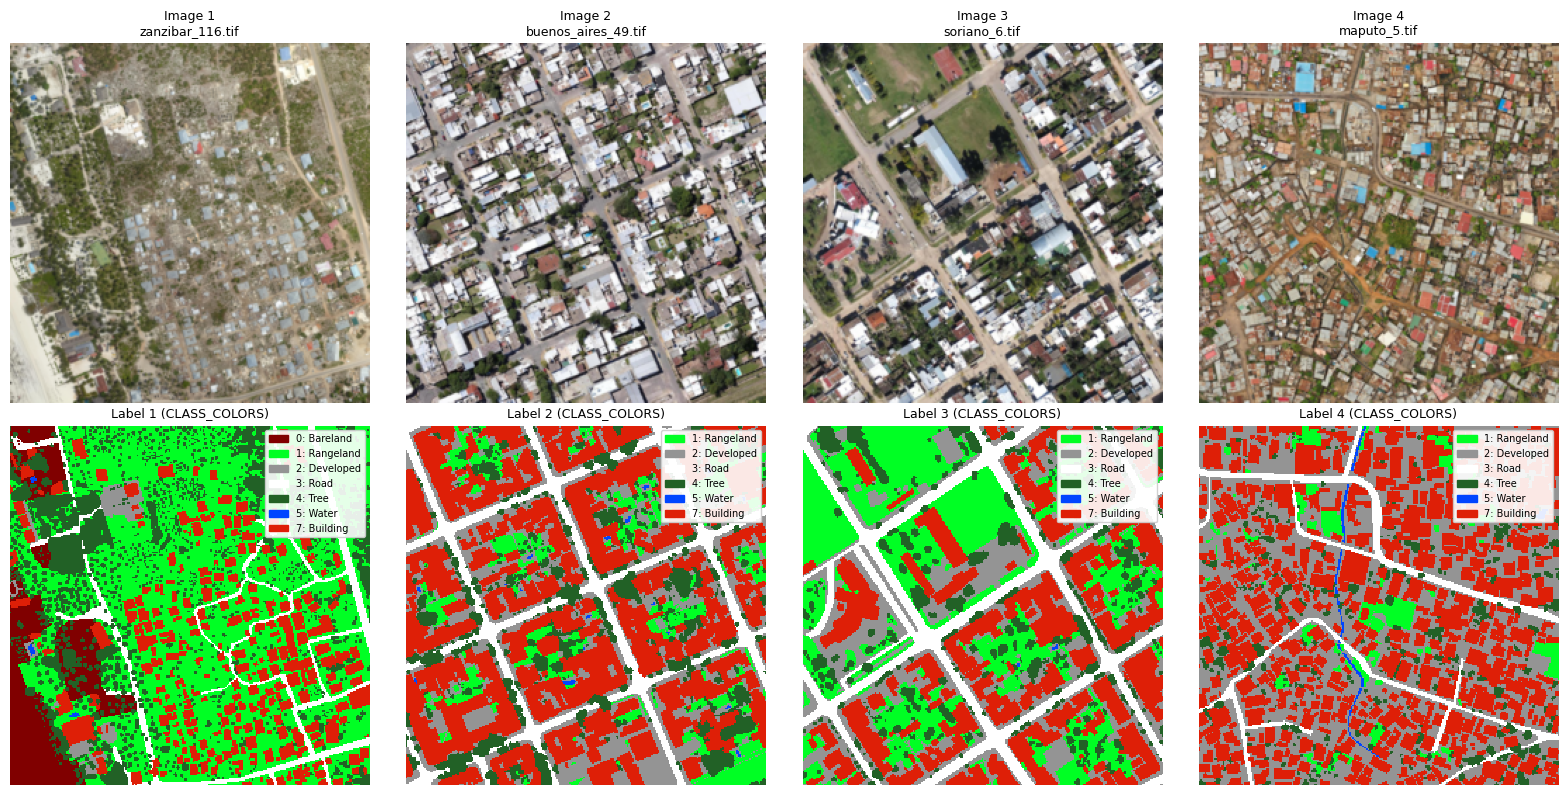

Batch visualization saved to 'batch_visualization.png'


In [ ]:
BATCH_SIZE = 4

# Force num_workers=0 on Windows to avoid multiprocessing issues
import sys
if sys.platform == 'win32':
    NUM_WORKERS = 0
    print(f"Windows detected: Setting NUM_WORKERS=0 to avoid multiprocessing issues")
else:
    # Check if NUM_WORKERS was already set in a previous cell
    if 'NUM_WORKERS' not in globals():
        NUM_WORKERS = 2  # Default for Linux/Colab
    print(f"Using NUM_WORKERS={NUM_WORKERS} (platform: {sys.platform})")


def decode_mask_ids_to_rgb(mask_ids: np.ndarray) -> np.ndarray:
    rgb = np.zeros((mask_ids.shape[0], mask_ids.shape[1], 3), dtype=np.uint8)
    for cls, color in CLASS_COLORS.items():
        rgb[mask_ids == cls] = np.array(color, dtype=np.uint8)
    return rgb


train_loader = data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True if torch.cuda.is_available() else False
)

val_loader = data.DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True if torch.cuda.is_available() else False
)

test_loader = data.DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True if torch.cuda.is_available() else False
)

print(f"DataLoaders created:")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches: {len(val_loader)}")
print(f"  Test batches: {len(test_loader)}")

# Visualize a batch
print("""
Visualizing a batch from train loader...""")
sample_batch = next(iter(train_loader))

print(f"Batch keys: {sample_batch.keys()}")
print(f"Image shape: {sample_batch['image'].shape}")
print(f"Label shape: {sample_batch['label'].shape}")
print(f"Image dtype: {sample_batch['image'].dtype}")
print(f"Label dtype: {sample_batch['label'].dtype}")
print(f"Image min/max: {sample_batch['image'].min():.3f} / {sample_batch['image'].max():.3f}")
print(f"Label min/max: {sample_batch['label'].min()} / {sample_batch['label'].max()}")

# Plot batch visualization
fig, axes = plt.subplots(2, BATCH_SIZE, figsize=(4 * BATCH_SIZE, 8))
if BATCH_SIZE == 1:
    axes = axes.reshape(2, 1)

for i in range(BATCH_SIZE):
    # Denormalize image for visualization
    img = sample_batch['image'][i].clone()
    for t, m, s in zip(img, NORM_MEAN_LIST, NORM_STD_LIST):
        t.mul_(s).add_(m)
    img = torch.clamp(img, 0, 1)

    # Convert to numpy
    img_np = img.permute(1, 2, 0).numpy()
    label_np = sample_batch['label'][i].numpy()

    # Plot image
    axes[0, i].imshow(img_np)
    axes[0, i].set_title(f"""Image {i+1}
{sample_batch['filename'][i]}""", fontsize=9)
    axes[0, i].axis('off')

    # Plot label (CLASS_COLORS)
    mask_rgb = encode_ids_to_rgb(
        label_np,
        CLASS_COLORS,
        ignore_index=IGNORE_INDEX,
        ignore_color=(0, 0, 0),
    )
    axes[1, i].imshow(mask_rgb, interpolation="nearest")
    axes[1, i].set_title(f"Label {i+1} (CLASS_COLORS)", fontsize=9)
    axes[1, i].axis('off')
    present_ids = np.unique(label_np)
    if IGNORE_INDEX is not None:
        present_ids = present_ids[present_ids != IGNORE_INDEX]
    make_legend(axes[1, i], CLASS_NAMES, CLASS_COLORS, present_ids=present_ids.tolist())

plt.tight_layout()
plt.savefig('batch_visualization.png', dpi=150, bbox_inches='tight')
plt.show()
print("Batch visualization saved to 'batch_visualization.png'")


## B6) Export Prepared Artifacts


Purpose: Runs a workflow step and updates notebook state.
Inputs: variables/files defined above. Outputs: updated variables, artifacts, or printed status.


Wrote data_locations.json to /content/drive/MyDrive/DL_project
Exporting prepared dataset...
train: exported 2149 files
val: exported 268 files
test: exported 270 files
infer_test: exported 1151 files
Split files written to prepared/splits/
Sanity checks:
  Train count: 2149 (expected 2149)
  Val count: 268 (expected 268)
  Test count: 270 (expected 270)
  Infer test count: 1151 (expected 1151)


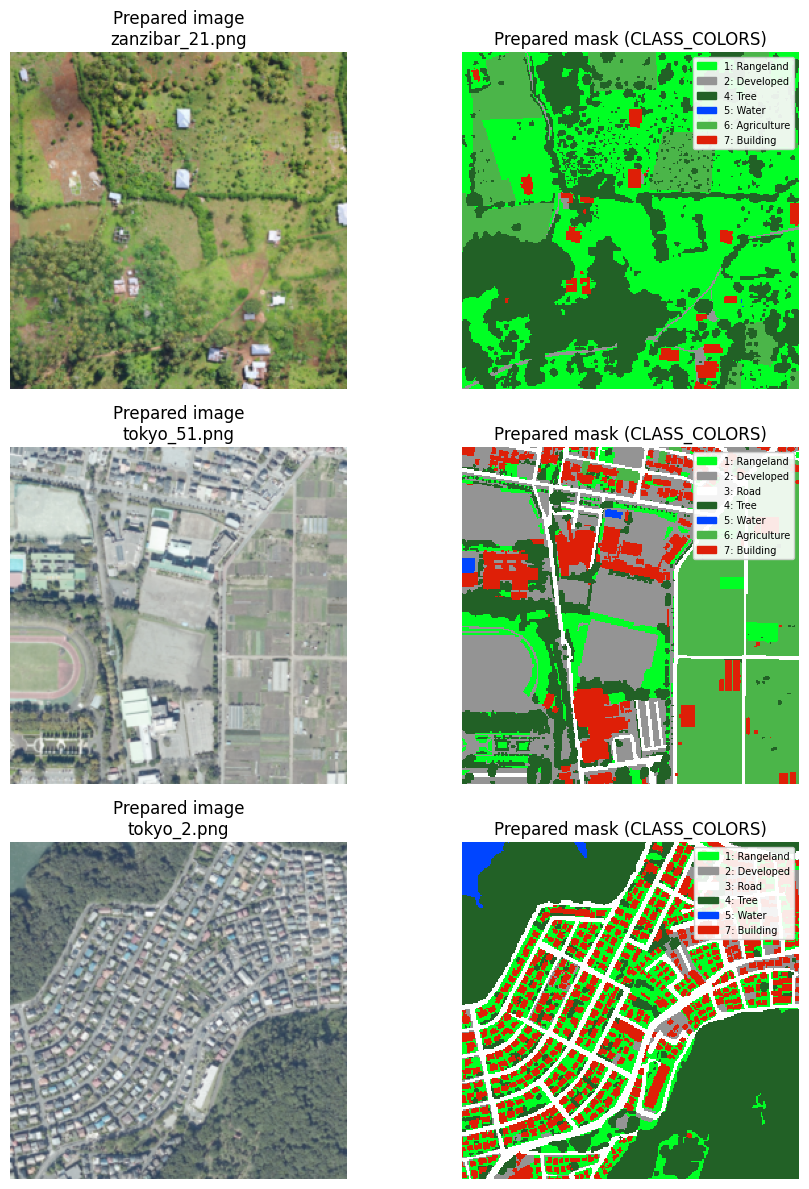

Saved prepared sample visualization to prepared/prepared_samples.png
Post-export check passed for train masks.
Post-export check passed for val masks.
Post-export check passed for test masks.


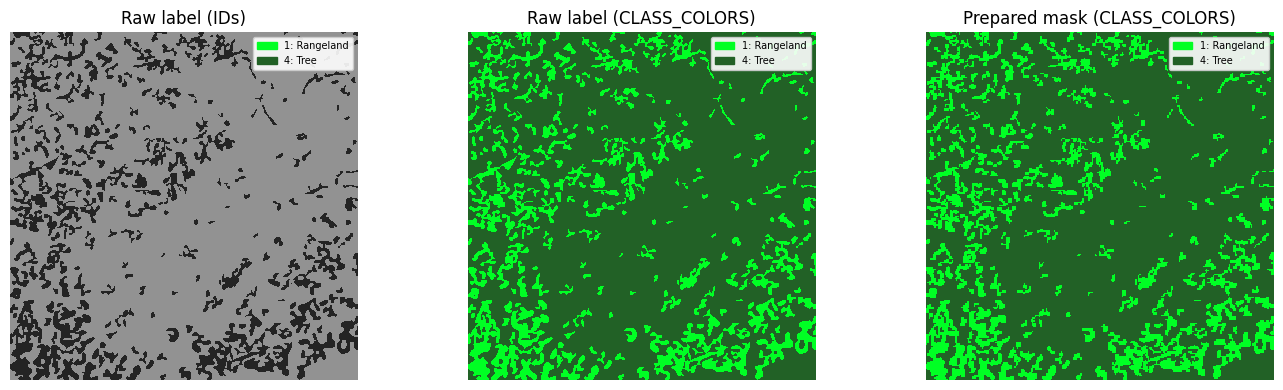

Saved label decoding sanity figure to prepared/label_decoding_sanity.png
Created meta.json
Created metadata.json
Prepared dataset summary:
  train: images=2149, masks=2149
  val: images=268, masks=268
  test: images=270, masks=270
  infer_test: images=1151, masks=0


In [ ]:
# Create prepared folder and export dataset
PREPARED_DIR = BASE_DIR / 'prepared'
PREPARED_DIR.mkdir(exist_ok=True)
prepared_splits_dir = PREPARED_DIR / 'splits'
prepared_splits_dir.mkdir(parents=True, exist_ok=True)

# FIX: Update data_locations.json
data_locations = {
    'project_dir': str(PROJECT_DIR),
    'raw_dir': str(RAW_DIR),
    'prepared_dir': str(PREPARED_DIR),
}
with open(PROJECT_DIR / 'data_locations.json', 'w') as f:
    json.dump(data_locations, f, indent=2)
print(f"Wrote data_locations.json to {PROJECT_DIR}")


prepared_images_dir = PREPARED_DIR / 'images'
prepared_masks_dir = PREPARED_DIR / 'masks'
for split in ['train', 'val', 'test']:
    (prepared_images_dir / split).mkdir(parents=True, exist_ok=True)
    (prepared_masks_dir / split).mkdir(parents=True, exist_ok=True)
(prepared_images_dir / 'infer_test').mkdir(parents=True, exist_ok=True)


def _output_name(filename: str) -> str:
    return Path(filename).with_suffix('.png').name


def _to_uint8(img: np.ndarray) -> np.ndarray:
    if img.dtype == np.uint8:
        return img
    if np.issubdtype(img.dtype, np.integer):
        max_val = np.iinfo(img.dtype).max
        if max_val > 0:
            img = img.astype(np.float32) / float(max_val) * 255.0
        else:
            img = img.astype(np.float32)
    else:
        if img.max() <= 1.0:
            img = img * 255.0
        elif img.max() > 255.0:
            img = img / img.max() * 255.0
    return np.clip(img, 0, 255).round().astype(np.uint8)


def _prepare_image(img: np.ndarray, size: Tuple[int, int]) -> Image.Image:
    if img.ndim == 2:
        img = np.stack([img] * 3, axis=-1)
    elif img.ndim == 3:
        if img.shape[2] > 3:
            img = img[:, :, :3]
        elif img.shape[0] == 3 and img.shape[2] != 3:
            img = np.transpose(img, (1, 2, 0))

    img = _to_uint8(img)
    img_pil = Image.fromarray(img)
    img_pil = img_pil.resize(size, Image.BILINEAR)
    return img_pil


def _prepare_mask(mask_raw: np.ndarray, size: Tuple[int, int]) -> Image.Image:
    # FIX: decode via canonical mapping
    class_mask = to_train_ids(mask_raw)
    mask_pil = Image.fromarray(class_mask.astype(np.uint8))
    # FIX: NEAREST for masks
    mask_pil = mask_pil.resize(size, Image.NEAREST)
    return mask_pil


def _mask_has_invalid_values(mask_np: np.ndarray) -> bool:
    if IGNORE_INDEX is None:
        invalid = (mask_np < 0) | (mask_np >= NUM_CLASSES)
    else:
        invalid = (mask_np < 0) | ((mask_np >= NUM_CLASSES) & (mask_np != IGNORE_INDEX))
    return bool(np.any(invalid))


def export_split(split_name: str, records: List[Dict[str, str]], has_labels: bool = True) -> List[str]:
    out_names = []
    missing = []
    invalid_masks = 0

    for record in records:
        filename = record["filename"]
        src_split = record["src_split"]

        img_path = IMAGES_DIR / src_split / filename
        if not img_path.exists():
            missing.append(filename)
            continue

        img = imread(str(img_path))
        img_pil = _prepare_image(img, IMG_SIZE)
        out_name = _output_name(filename)
        img_pil.save(prepared_images_dir / split_name / out_name, format='PNG')

        if has_labels:
            label_path = LABEL_DIR / src_split / filename
            if not label_path.exists():
                missing.append(filename)
                continue
            label_raw = load_label_raw(label_path)
            mask_pil = _prepare_mask(label_raw, IMG_SIZE)
            mask_np = np.array(mask_pil, dtype=np.uint8)
            if _mask_has_invalid_values(mask_np):
                invalid_masks += 1
            mask_pil.save(prepared_masks_dir / split_name / out_name, format='PNG')

        out_names.append(out_name)

    print(f"{split_name}: exported {len(out_names)} files")
    if missing:
        print(f"  Missing files: {len(missing)}")
    if invalid_masks:
        print(f"  Invalid masks detected: {invalid_masks}")

    return out_names


print("Exporting prepared dataset...")
train_out = export_split('train', train_labeled_records, has_labels=True)
val_out = export_split('val', val_labeled_records, has_labels=True)
test_out = export_split('test', test_labeled_records, has_labels=True)
infer_test_out = export_split('infer_test', infer_test_records, has_labels=False)

# Write split files
(prepared_splits_dir / 'train_labeled.txt').write_text('\n'.join(train_out) + '\n')
(prepared_splits_dir / 'val_labeled.txt').write_text('\n'.join(val_out) + '\n')
(prepared_splits_dir / 'test_labeled.txt').write_text('\n'.join(test_out) + '\n')
(prepared_splits_dir / 'infer_test.txt').write_text('\n'.join(infer_test_out) + '\n')

print("Split files written to prepared/splits/")

# Sanity checks
print("Sanity checks:")
print(f"  Train count: {len(train_out)} (expected {len(train_labeled_files)})")
print(f"  Val count: {len(val_out)} (expected {len(val_labeled_files)})")
print(f"  Test count: {len(test_out)} (expected {len(test_labeled_files)})")
print(f"  Infer test count: {len(infer_test_out)} (expected {len(infer_test_files)})")

# Visual check: 3 random samples from prepared
sample_count = min(3, len(train_out))
if sample_count > 0:
    sample_files = random.sample(train_out, sample_count)
    fig, axes = plt.subplots(sample_count, 2, figsize=(10, 4 * sample_count))
    if sample_count == 1:
        axes = axes.reshape(1, -1)

    for i, fname in enumerate(sample_files):
        img = np.array(Image.open(prepared_images_dir / 'train' / fname))
        mask_ids = np.array(Image.open(prepared_masks_dir / 'train' / fname))
        mask_rgb = encode_ids_to_rgb(
            mask_ids,
            CLASS_COLORS,
            ignore_index=IGNORE_INDEX,
            ignore_color=(0, 0, 0),
        )
        axes[i, 0].imshow(img)
        axes[i, 0].set_title(f"Prepared image\n{fname}")
        axes[i, 0].axis('off')

        axes[i, 1].imshow(mask_rgb, interpolation="nearest")
        axes[i, 1].set_title("Prepared mask (CLASS_COLORS)")
        axes[i, 1].axis('off')
        present_ids = np.unique(mask_ids)
        if IGNORE_INDEX is not None:
            present_ids = present_ids[present_ids != IGNORE_INDEX]
        make_legend(axes[i, 1], CLASS_NAMES, CLASS_COLORS, present_ids=present_ids.tolist())

    plt.tight_layout()
    plt.savefig(PREPARED_DIR / 'prepared_samples.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("Saved prepared sample visualization to prepared/prepared_samples.png")


# Post-export check: sample prepared masks for valid training IDs
for split_name, out_list in [("train", train_out), ("val", val_out), ("test", test_out)]:
    sample_check = random.sample(out_list, min(5, len(out_list)))
    if not sample_check:
        print(f"Post-export check skipped: no prepared masks to check for {split_name}.")
        continue
    allowed = set(range(NUM_CLASSES)) | {IGNORE_INDEX}
    for fname in sample_check:
        mask = np.array(Image.open(prepared_masks_dir / split_name / fname))
        if mask.ndim != 2:
            raise ValueError(f"Prepared mask {split_name}/{fname} is not 2D: shape={mask.shape}")
        if mask.dtype != np.uint8:
            raise ValueError(f"Prepared mask {split_name}/{fname} is not uint8: dtype={mask.dtype}")
        unique_vals = np.unique(mask)
        bad = [int(v) for v in unique_vals if int(v) not in allowed]
        if bad:
            raise ValueError(f"Prepared mask {split_name}/{fname} has unexpected values: {bad}")
        if 8 in unique_vals:
            raise ValueError(f"Prepared mask {split_name}/{fname} still contains value 8")
    print(f"Post-export check passed for {split_name} masks.")


# Label Decoding Sanity Figure
if train_labeled_records:
    raw_record = train_labeled_records[0]
    raw_name = raw_record["filename"]
    prepared_name = _output_name(raw_name)
    raw_label = load_label_raw(LABEL_DIR / raw_record["src_split"] / raw_name)
    raw_ids = to_train_ids(raw_label)
    prepared_ids = np.array(Image.open(prepared_masks_dir / 'train' / prepared_name))

    raw_rgb = encode_ids_to_rgb(
        raw_ids,
        CLASS_COLORS,
        ignore_index=IGNORE_INDEX,
        ignore_color=(0, 0, 0),
    )
    prepared_rgb = encode_ids_to_rgb(
        prepared_ids,
        CLASS_COLORS,
        ignore_index=IGNORE_INDEX,
        ignore_color=(0, 0, 0),
    )

    fig, axes = plt.subplots(1, 3, figsize=(14, 4))
    axes[0].imshow(raw_ids, cmap='gray', vmin=0, vmax=NUM_CLASSES - 1, interpolation="nearest")
    axes[0].set_title('Raw label (IDs)')
    axes[0].axis('off')
    present_ids = np.unique(raw_ids)
    if IGNORE_INDEX is not None:
        present_ids = present_ids[present_ids != IGNORE_INDEX]
    make_legend(axes[0], CLASS_NAMES, CLASS_COLORS, present_ids=present_ids.tolist())

    axes[1].imshow(raw_rgb, interpolation="nearest")
    axes[1].set_title('Raw label (CLASS_COLORS)')
    axes[1].axis('off')
    make_legend(axes[1], CLASS_NAMES, CLASS_COLORS, present_ids=present_ids.tolist())

    axes[2].imshow(prepared_rgb, interpolation="nearest")
    axes[2].set_title('Prepared mask (CLASS_COLORS)')
    axes[2].axis('off')
    present_ids = np.unique(prepared_ids)
    if IGNORE_INDEX is not None:
        present_ids = present_ids[present_ids != IGNORE_INDEX]
    make_legend(axes[2], CLASS_NAMES, CLASS_COLORS, present_ids=present_ids.tolist())

    plt.tight_layout()
    plt.savefig(PREPARED_DIR / 'label_decoding_sanity.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("Saved label decoding sanity figure to prepared/label_decoding_sanity.png")

# Create meta.json
meta = {
    'dataset_name': 'OpenEarthMap',
    'num_classes': NUM_CLASSES,
    'class_names': CLASS_NAMES,
    'class_colors': {str(k): list(v) for k, v in CLASS_COLORS.items()},
    'vegetation_ids': VEGETATION_IDS,
    'water_id': WATER_ID,
    'splits': {
        'train': len(train_out),
        'val': len(val_out),
        'test': len(test_out),
        'infer_test': len(infer_test_out)
    },
    'image_size': list(IMG_SIZE),
}
if IGNORE_INDEX is not None:
    meta['ignore_index'] = IGNORE_INDEX

with open(PREPARED_DIR / 'meta.json', 'w') as f:
    json.dump(meta, f, indent=2)

print("Created meta.json")

# Create metadata.json (extended)
metadata = {
    'dataset_name': 'OpenEarthMap',
    'num_classes': NUM_CLASSES,
    'class_names': CLASS_NAMES,
    'class_colors': {str(k): list(v) for k, v in CLASS_COLORS.items()},
    'vegetation_ids': VEGETATION_IDS,
    'water_id': WATER_ID,
    'splits': {
        'train': len(train_out),
        'val': len(val_out),
        'test': len(test_out),
        'infer_test': len(infer_test_out)
    },
    'class_distribution': {
        'train': {str(k): int(v) for k, v in train_class_counts.items()},
        'val': {str(k): int(v) for k, v in val_class_counts.items()}
    },
    'normalization': {
        'mean': NORM_MEAN_LIST,
        'std': NORM_STD_LIST
    },
    'image_size': list(IMG_SIZE),
    'batch_size': BATCH_SIZE
}
if IGNORE_INDEX is not None:
    metadata['ignore_index'] = IGNORE_INDEX

with open(PREPARED_DIR / 'metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)

print("Created metadata.json")

# Confirm counts in prepared folder
def _count_files(dir_path, suffix=".png"):
    if not dir_path.exists():
        return 0
    return len([p for p in dir_path.iterdir() if p.is_file() and p.suffix.lower() == suffix])

print("Prepared dataset summary:")
for split in ["train", "val", "test"]:
    img_count = _count_files(prepared_images_dir / split)
    mask_count = _count_files(prepared_masks_dir / split)
    print(f"  {split}: images={img_count}, masks={mask_count}")

infer_img_count = _count_files(prepared_images_dir / 'infer_test')
print(f"  infer_test: images={infer_img_count}, masks=0")


---
# Final Checklist & Next Steps


Purpose: Runs a workflow step and updates notebook state.
Inputs: variables/files defined above. Outputs: updated variables, artifacts, or printed status.


In [ ]:
print("=" * 80)
print("DATASET PREPARED âœ…")
print("=" * 80)
print("\nCHECKLIST:")
print("  âœ… Splits loaded (train, val, test)")
print("  âœ… File integrity checked")
print("  âœ… Image/label dimensions verified")
print("  âœ… Label colors validated")
print("  âœ… Class distribution computed")
print("  âœ… Normalization strategy decided")
print("  âœ… PyTorch Dataset class created")
print("  âœ… DataLoaders ready")
print("  âœ… Artifacts exported")




DATASET PREPARED âœ…

CHECKLIST:
  âœ… Splits loaded (train, val, test)
  âœ… File integrity checked
  âœ… Image/label dimensions verified
  âœ… Label colors validated
  âœ… Class distribution computed
  âœ… Normalization strategy decided
  âœ… PyTorch Dataset class created
  âœ… DataLoaders ready
  âœ… Artifacts exported


## FINAL SANITY CHECK


Purpose: Runs a workflow step and updates notebook state.
Inputs: variables/files defined above. Outputs: updated variables, artifacts, or printed status.


FINAL SANITY CHECK
Class mapping:
  0: Bareland -> (128, 0, 0)
  1: Rangeland -> (0, 255, 36)
  2: Developed -> (148, 148, 148)
  3: Road -> (255, 255, 255)
  4: Tree -> (34, 97, 38)
  5: Water -> (0, 69, 255)
  6: Agriculture -> (75, 181, 73)
  7: Building -> (222, 31, 7)
Vegetation IDs: [4, 1, 6]
Water ID: 5
IGNORE_INDEX: 255
Raw sample: aachen_1.tif
Raw unique IDs: [1, 2, 3, 4, 5, 6, 7, 255]
Prepared sample: zanzibar_54.png
Prepared unique IDs: [1, 4]


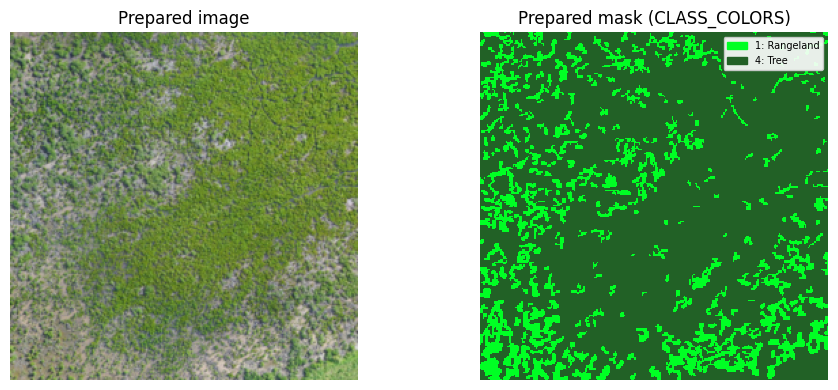


Prepared split counts:
  train: images=2149, masks=2149
  val: images=268, masks=268
  test: images=270, masks=270
  infer_test: images=1151, masks=0

Prepared mask value sanity check (train/val/test):
  train: checking 5 masks
  val: checking 5 masks
  test: checking 5 masks
Prepared mask sanity checks passed.


In [ ]:
print("=" * 80)
print("FINAL SANITY CHECK")
print("=" * 80)

print("Class mapping:")
for idx in range(NUM_CLASSES):
    print(f"  {idx}: {CLASS_NAMES[idx]} -> {CLASS_COLORS[idx]}")
print(f"Vegetation IDs: {VEGETATION_IDS}")
print(f"Water ID: {WATER_ID}")
print(f"IGNORE_INDEX: {IGNORE_INDEX}")

raw_sample = train_files[0] if train_files else None
if raw_sample:
    raw_label = load_label_raw(LABEL_DIR / 'train' / raw_sample)
    raw_ids = to_train_ids(raw_label)
    print(f"Raw sample: {raw_sample}")
    print(f"Raw unique IDs: {np.unique(raw_ids).tolist()}")

prepared_sample = train_out[0] if 'train_out' in globals() and train_out else None
if prepared_sample:
    prepared_ids = np.array(Image.open(prepared_masks_dir / 'train' / prepared_sample))
    print(f"Prepared sample: {prepared_sample}")
    print(f"Prepared unique IDs: {np.unique(prepared_ids).tolist()}")

    img = np.array(Image.open(prepared_images_dir / 'train' / prepared_sample))
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    axes[0].imshow(img)
    axes[0].set_title('Prepared image')
    axes[0].axis('off')

    mask_rgb = encode_ids_to_rgb(
        prepared_ids,
        CLASS_COLORS,
        ignore_index=IGNORE_INDEX,
        ignore_color=(0, 0, 0),
    )
    axes[1].imshow(mask_rgb, interpolation="nearest")
    axes[1].set_title('Prepared mask (CLASS_COLORS)')
    axes[1].axis('off')
    present_ids = np.unique(prepared_ids)
    if IGNORE_INDEX is not None:
        present_ids = present_ids[present_ids != IGNORE_INDEX]
    make_legend(axes[1], CLASS_NAMES, CLASS_COLORS, present_ids=present_ids.tolist())

    plt.tight_layout()
    plt.show()

print("\nPrepared split counts:")
train_img_count = _count_files(prepared_images_dir / 'train')
train_mask_count = _count_files(prepared_masks_dir / 'train')
val_img_count = _count_files(prepared_images_dir / 'val')
val_mask_count = _count_files(prepared_masks_dir / 'val')
test_img_count = _count_files(prepared_images_dir / 'test')
test_mask_count = _count_files(prepared_masks_dir / 'test')
infer_img_count = _count_files(prepared_images_dir / 'infer_test')
print(f"  train: images={train_img_count}, masks={train_mask_count}")
print(f"  val: images={val_img_count}, masks={val_mask_count}")
print(f"  test: images={test_img_count}, masks={test_mask_count}")
print(f"  infer_test: images={infer_img_count}, masks=0")

if not (prepared_masks_dir / 'test').exists():
    raise FileNotFoundError(f"Missing prepared test masks dir: {prepared_masks_dir / 'test'}")
if test_img_count != test_mask_count:
    raise ValueError("Prepared test image/mask counts do not match")

# Sanity check: sample 5 masks per split
print("\nPrepared mask value sanity check (train/val/test):")
allowed = set(range(NUM_CLASSES)) | {IGNORE_INDEX}
for split_name, out_list in [("train", train_out), ("val", val_out), ("test", test_out)]:
    sample_check = random.sample(out_list, min(5, len(out_list)))
    print(f"  {split_name}: checking {len(sample_check)} masks")
    for fname in sample_check:
        mask = np.array(Image.open(prepared_masks_dir / split_name / fname))
        if mask.ndim != 2:
            raise ValueError(f"Prepared mask {split_name}/{fname} is not 2D: shape={mask.shape}")
        unique_vals = np.unique(mask)
        bad = [int(v) for v in unique_vals if int(v) not in allowed]
        if bad:
            raise ValueError(f"Prepared mask {split_name}/{fname} has unexpected values: {bad}")
print("Prepared mask sanity checks passed.")
